In [ ]:
# ---- Instalar libs somente se não existirem ---- 1
def ensure(pkg, import_name=None, version=None):
    import importlib
    name = import_name or pkg
    try:
        importlib.import_module(name)
    except ImportError:
        spec = pkg if version is None else f"{pkg}=={version}"
        import IPython
        IPython.get_ipython().run_line_magic(
            "pip", f"install -q --disable-pip-version-check --no-python-version-warning {spec}"
        )

# Pins leves para evitar o resolvedor demorado
ensure("pandas", "pandas", "2.2.2")
ensure("gspread", "gspread", "6.1.2")
ensure("gspread-dataframe", "gspread_dataframe", "3.3.1")
ensure("phonenumbers", "phonenumbers", "8.13.43")
ensure("mlxtend", "mlxtend", "0.23.1")

import pandas as pd
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from google.colab import drive
from datetime import datetime, timedelta
import numpy as np
import phonenumbers
import re
from collections import Counter
import warnings
import calendar
import time
import os

# Suprimir warnings
warnings.filterwarnings("ignore", message="datetime.datetime.utcnow() is deprecated")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client.session")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# === CONFIGURAÇÕES ===
ANALISE_PERIODO_FOCO = "mensal"
MESES_COMPARACAO = 3
INCLUIR_ANO_ANTERIOR = True
ALERTAS_ATIVOS = True
THRESHOLD_QUEDA = 20
THRESHOLD_PICO = 50
THRESHOLD_CRITICO = 30

# --- Montar Google Drive (idempotente) ---
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive', force_remount=False)
else:
    print("Drive já montado.")

# Caminho fixo para credenciais
creds_file = "/content/drive/MyDrive/GKEY.json"
gc = gspread.service_account(filename=creds_file)

# --- Abrir planilha ---
spreadsheet = gc.open("Photos")
print("📄 Iniciando análise...")

# --- Ler dados brutos ---
sheet_leads = spreadsheet.worksheet("Leads")
df_bruto = pd.DataFrame(sheet_leads.get_all_records())
print(f"📊 {len(df_bruto)} registros encontrados")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.9 MB/s eta 0:00:00
Mounted at /content/drive
📄 Iniciando análise...
📊 31 registros encontrados


In [ ]:
# === FUNÇÕES DE LIMPEZA === 2
def limpar_email(email):
    if pd.isna(email) or email == '':
        return ''
    return str(email).lower().strip()

def limpar_telefone(phone):
    if pd.isna(phone) or phone == '':
        return ''
    try:
        phone_clean = re.sub(r'[^\d+]', '', str(phone))
        if not phone_clean.startswith('+'):
            if phone_clean.startswith('55'):
                phone_clean = '+' + phone_clean
            else:
                phone_clean = '+55' + phone_clean
        parsed = phonenumbers.parse(phone_clean, None)
        if phonenumbers.is_valid_number(parsed):
            return phonenumbers.format_number(parsed, phonenumbers.PhoneNumberFormat.E164)
        return phone_clean
    except:
        return str(phone)

def normalizar_utm(utm_value):
    if pd.isna(utm_value) or utm_value == '':
        return 'direct'
    return str(utm_value).lower().strip()

def extrair_essencias(selection_text):
    if pd.isna(selection_text) or selection_text == '':
        return []
    essencias = []
    partes = str(selection_text).split('|')
    for parte in partes:
        if '(+)' in parte or '(-)' in parte:
            essencia = parte.split(') ')[-1].strip()
            if essencia:
                essencias.append(essencia)
    return essencias

# ===== GEO helpers =====
from phonenumbers import geocoder as pgeo

DDD_UF = {
 "11":"SP","12":"SP","13":"SP","14":"SP","15":"SP","16":"SP","17":"SP","18":"SP","19":"SP",
 "21":"RJ","22":"RJ","24":"RJ","27":"ES","28":"ES",
 "31":"MG","32":"MG","33":"MG","34":"MG","35":"MG","37":"MG","38":"MG",
 "41":"PR","42":"PR","43":"PR","44":"PR","45":"PR","46":"PR",
 "47":"SC","48":"SC","49":"SC",
 "51":"RS","53":"RS","54":"RS","55":"RS",
 "61":"DF","62":"GO","64":"GO","63":"TO","65":"MT","66":"MT","67":"MS",
 "68":"AC","69":"RO",
 "71":"BA","73":"BA","74":"BA","75":"BA","77":"BA",
 "79":"SE",
 "81":"PE","87":"PE","82":"AL","83":"PB","84":"RN","85":"CE","88":"CE",
 "86":"PI","89":"PI","91":"PA","93":"PA","94":"PA",
 "92":"AM","97":"AM","95":"RR","96":"AP","98":"MA","99":"MA"
}

def inferir_geo_por_telefone(phone_e164: str):
    pais, uf = "", ""
    try:
        if isinstance(phone_e164, str) and phone_e164:
            num = phonenumbers.parse(phone_e164, None)
            rc = phonenumbers.region_code_for_number(num)
            pais = rc or ""
            if rc == "BR":
                m = re.match(r"^\+55(\d{2})", phone_e164)
                if m:
                    uf = DDD_UF.get(m.group(1), "")
            if not uf:
                uf = pgeo.description_for_number(num, "pt")
    except Exception:
        pass
    return (pais, uf)

In [ ]:
# === LOGGER E ALERT ENGINE === 2  (NOVO)

import json, time, uuid, sys
from datetime import datetime, timezone

LOG_LEVEL = "INFO"  # DEBUG/INFO/WARN/ERROR
_alerts_accumulator = []  # acumula alertas para a aba "Alertas"

def _now_iso():
    return datetime.now(timezone.utc).isoformat()

def log(level, msg, **kv):
    levels = ["DEBUG","INFO","WARN","ERROR"]
    if levels.index(level) < levels.index(LOG_LEVEL):
        return
    rec = {"ts": _now_iso(), "level": level, "msg": msg, **kv}
    print(json.dumps(rec, ensure_ascii=False))

def log_start(stage, **kv):
    kv.setdefault("stage", stage)
    kv["event"] = "start"
    log("INFO", f"START {stage}", **kv)

def log_end(stage, **kv):
    kv.setdefault("stage", stage)
    kv["event"] = "end"
    log("INFO", f"END {stage}", **kv)

def alert(code, severity="WARN", hint="", **kv):
    rec = {"ts": _now_iso(), "code": code, "severity": severity, "hint": hint, **kv}
    _alerts_accumulator.append(rec)
    log("WARN" if severity!="ERROR" else "ERROR", f"ALERT {code}", **rec)

def flush_alerts_df():
    import pandas as pd
    if not _alerts_accumulator:
        return pd.DataFrame(columns=["ts","severity","code","hint","ctx"])
    df = pd.DataFrame(_alerts_accumulator)
    # contexto extra em uma coluna única
    extra_cols = [c for c in df.columns if c not in ["ts","severity","code","hint"]]
    if extra_cols:
        df["ctx"] = df[extra_cols].apply(lambda r: {k: r[k] for k in extra_cols if pd.notna(r[k])}, axis=1)
        df = df[["ts","severity","code","hint","ctx"]]
    return df.sort_values(["severity","ts"], ascending=[False, True]).reset_index(drop=True)

log_start("Notebook")


{"ts": "2025-09-30T13:16:17.524392+00:00", "level": "INFO", "msg": "START Notebook", "stage": "Notebook", "event": "start"}


In [ ]:
# === FORÇAR REPROCESSAMENTO TOTAL === 3
# Deletar Leads_clean para garantir processamento completo
try:
    sheet_clean = spreadsheet.worksheet("Leads_clean")
    spreadsheet.del_worksheet(sheet_clean)
    print("✅ Aba Leads_clean deletada para reprocessamento")
    time.sleep(1)
except:
    pass

# === PROCESSAMENTO DOS DADOS ===
print(f"🆕 Processando todos os {len(df_bruto)} registros")

df_limpo = df_bruto.copy()
df_limpo['timestamp'] = pd.to_datetime(df_limpo['timestamp'], errors='coerce')
df_limpo['email_clean'] = df_limpo['email'].apply(limpar_email)

# Telefones
if 'phone_e164' in df_limpo.columns:
    df_limpo['phone_e164_clean'] = df_limpo['phone_e164'].astype(str).str.strip()
    mask_nao_e164 = ~df_limpo['phone_e164_clean'].str.startswith('+', na=False)
    df_limpo.loc[mask_nao_e164, 'phone_e164_clean'] = df_limpo.loc[mask_nao_e164, 'phone'].apply(limpar_telefone)
else:
    df_limpo['phone_e164_clean'] = df_limpo['phone'].apply(limpar_telefone)

# UTM / Essências
df_limpo['utm_source_clean'] = df_limpo['utm_source'].apply(normalizar_utm)
df_limpo['utm_medium_clean'] = df_limpo['utm_medium'].apply(normalizar_utm)
df_limpo['utm_campaign_clean'] = df_limpo['utm_campaign'].apply(normalizar_utm)
df_limpo['essencias_lista'] = df_limpo['selection'].apply(extrair_essencias)

from zoneinfo import ZoneInfo
TZ = ZoneInfo("America/Sao_Paulo")

# timestamp bruto -> UTC (se já vier em UTC, isso só garante coerção)
df_limpo["timestamp"] = pd.to_datetime(df_limpo["timestamp"], errors="coerce", utc=True)

# crie uma coluna LOCAL (sem tz) só para features
ts_local = df_limpo["timestamp"].dt.tz_convert(TZ)

# features **no horário local**
df_limpo["data"]        = ts_local.dt.date
df_limpo["hora"]        = ts_local.dt.hour
df_limpo["dia_semana"]  = ts_local.dt.day_name()
df_limpo["semana_iso"]  = ts_local.dt.isocalendar().week.astype(int)
df_limpo["mes"]         = ts_local.dt.month
df_limpo["ano"]         = ts_local.dt.year

# Preço numérico (necessário)
df_limpo["price_num"] = pd.to_numeric(df_limpo.get("price"), errors="coerce")
df_limpo.loc[df_limpo["price_num"] < 0, "price_num"] = np.nan  # evita negativos

# GEO
geo_pairs = df_limpo['phone_e164_clean'].apply(inferir_geo_por_telefone)
geo_df = pd.DataFrame(geo_pairs.tolist(), columns=['pais_inferido','estado_inferido'])
df_limpo['pais_inferido'] = geo_df['pais_inferido']
df_limpo['estado_inferido'] = geo_df['estado_inferido']

# CORREÇÃO CRÍTICA: Usar 'action' para identificar pagamentos
df_limpo['is_paid'] = df_limpo['action'] == 'paid'

# === Normalização de idade (consolida por pessoa) ===
import numpy as np
import pandas as pd

# 1) person_id robusto (email -> phone)
df_limpo["person_id"] = df_limpo["email_clean"]
m = df_limpo["person_id"].eq("") | df_limpo["person_id"].isna()
df_limpo.loc[m, "person_id"] = df_limpo.loc[m, "phone_e164_clean"]

# 2) coerção e saneamento de idade
df_limpo["age"] = pd.to_numeric(df_limpo.get("age"), errors="coerce")
df_limpo.loc[(df_limpo["age"] < 0) | (df_limpo["age"] > 120), "age"] = np.nan

# 3) última idade conhecida por pessoa (ordem por timestamp) — renomeia p/ não colidir
lead_last_age = (
    df_limpo.sort_values("timestamp")
            .dropna(subset=["person_id"])
            .dropna(subset=["age"])
            .groupby("person_id", as_index=False)
            .tail(1)[["person_id","age"]]
            .rename(columns={"age": "age_from_events"})
)

# 4) merge sem suffixes + coalesce e limpeza
df_limpo = df_limpo.merge(lead_last_age, on="person_id", how="left")  # sem suffixes
df_limpo["age"] = df_limpo["age"].fillna(df_limpo["age_from_events"])
df_limpo.drop(columns=["age_from_events"], inplace=True)

# 5) faixas etárias
df_limpo["age_num"] = pd.cut(
    df_limpo["age"],
    bins=[-np.inf, 17, 25, 35, 45, 55, 150],
    labels=["<18","18-25","26-35","36-45","46-55","55+"],
    right=True
)

# Salvar dados limpos
from gspread_dataframe import set_with_dataframe
sheet_clean = spreadsheet.add_worksheet(title="Leads_clean", rows=5000, cols=50)
set_with_dataframe(sheet_clean, df_limpo, row=1, col=1, include_index=False)
print("✅ Dados limpos salvos")


✅ Aba Leads_clean deletada para reprocessamento
🆕 Processando todos os 31 registros
✅ Dados limpos salvos


In [ ]:
# === PREPROCESS + STRIPE LINKER (híbrido, vetorizado) === 4 e 5
from datetime import datetime, timedelta
import pytz, numpy as np, pandas as pd

TZ = pytz.timezone("America/Sao_Paulo")

def to_local_date(s):
    x = pd.to_datetime(s, errors="coerce", utc=True)
    try:
        return x.dt.tz_convert(TZ).dt.date
    except Exception:
        x = pd.to_datetime(s, errors="coerce")
        return x.dt.tz_localize(TZ, nonexistent="shift_forward", ambiguous="NaT").dt.date

def norm_email(s): return (s or "").strip().lower()
def norm_name(s): return " ".join((s or "").strip().lower().split())

def norm_phone(s):
    s = (s or "").strip()
    if s.startswith("+") and s[1:].isdigit():
        return s
    d = "".join(ch for ch in s if ch.isdigit())
    if len(d) >= 11:
        return "+55" + d[-11:]
    return d or ""

def build_identity_key(row: pd.Series) -> str | None:
    e = norm_email(row.get("email_clean") or row.get("email", ""))
    p = norm_phone(row.get("phone_e164_clean") or row.get("phone_e164") or row.get("phone", ""))
    n = norm_name(row.get("name", ""))
    if e: return f"email:{e}"
    if p: return f"phone:{p}"
    if n and p: return f"name_phone:{n}|{p}"
    return None

# --- Normalização mínima
df_limpo = df_limpo.copy()
if "data" not in df_limpo or not np.issubdtype(df_limpo["data"].dtype, np.datetime64):
    df_limpo["data"] = to_local_date(df_limpo.get("timestamp", df_limpo.index))

# --- Identificação de eventos Stripe
is_stripe = (
    (df_limpo.get("origin", "").astype(str).str.lower() == "stripe") |
    (df_limpo.get("userAgent", "").astype(str).str.contains("stripe", case=False, na=False)) |
    (df_limpo.get("action", "").astype(str).str.lower() == "paid") |
    (df_limpo.get("kind", "").astype(str).str.lower() == "pagamentoconfirmado") |
    (df_limpo.get("subject", "").astype(str).str.contains("Pagamento Confirmado", case=False, na=False))
)

df_limpo["__identity_raw"] = df_limpo.apply(build_identity_key, axis=1)
MISSING = "__MISSING__"
df_limpo["__identity"] = df_limpo["__identity_raw"].where(df_limpo["__identity_raw"].notna(), MISSING).astype(str)
df_limpo["__ts"] = pd.to_datetime(df_limpo.get("timestamp", datetime.now()), errors="coerce", utc=True)

# --- Split
df_user = df_limpo.loc[~is_stripe].copy()
df_stripe = df_limpo.loc[is_stripe].copy()

print(f"🔍 Separação - Usuários: {len(df_user)}, Stripe: {len(df_stripe)}")

# --- LINKING heurístico (mantém compatibilidade com histórico)
window = pd.Timedelta(minutes=20)
linked_sessions = []
orphan_payments = []
linking_stats = {"email_match": 0, "phone_match": 0, "name_phone_match": 0, "no_match": 0}

valid_users = df_user[df_user["__identity"] != MISSING].copy()
valid_users["__identity"] = valid_users["__identity"].astype(str)
user_by_identity = valid_users.groupby("__identity", sort=False, dropna=False)

for idx, stripe_row in df_stripe.iterrows():
    identity = str(stripe_row["__identity"])
    if identity == MISSING or pd.isna(identity):
        linked_sessions.append(None); orphan_payments.append(idx); linking_stats["no_match"] += 1; continue
    stripe_ts = stripe_row["__ts"]; linked_session = None; match_type = None
    if identity in user_by_identity.groups:
        candidates = user_by_identity.get_group(identity)
        time_filtered = candidates[(candidates["__ts"] >= stripe_ts - window) & (candidates["__ts"] <= stripe_ts + window)]
        if len(time_filtered) > 0:
            closest = time_filtered.loc[(time_filtered["__ts"] - stripe_ts).abs().idxmin()]
            linked_session = closest["event_id"]
            if identity.startswith("email:"): match_type = "email_match"
            elif identity.startswith("phone:"): match_type = "phone_match"
            elif identity.startswith("name_phone:"): match_type = "name_phone_match"
            if match_type: linking_stats[match_type] += 1
    if linked_session: linked_sessions.append(linked_session)
    else: linked_sessions.append(None); orphan_payments.append(idx); linking_stats["no_match"] += 1

df_stripe["session_id_linked"] = linked_sessions
df_stripe["is_orphan"] = df_stripe.index.isin(orphan_payments)

# --- ENRIQUECIMENTO híbrido, vetorizado ---
to_copy = ["age","selection","phone_e164","phone_e164_clean","name","email","email_clean"]
session_meta = df_user[["event_id"] + to_copy].drop_duplicates("event_id").set_index("event_id").add_suffix("_from_session")

if "event_id_linked" in df_stripe.columns and df_stripe["event_id_linked"].notna().any():
    # usa event_id_linked
    df_stripe = df_stripe.merge(session_meta, how="left", left_on="event_id_linked", right_index=True)
else:
    # fallback para session_id_linked
    df_stripe = df_stripe.merge(session_meta, how="left", left_on="session_id_linked", right_index=True)

# Preencher campos vazios com dados da sessão
for col in to_copy:
    src = f"{col}_from_session"
    if src in df_stripe.columns:
        df_stripe[col] = df_stripe[col].where(df_stripe[col].notna() & (df_stripe[col].astype(str) != ""), df_stripe[src])

# Flag de enriquecimento
changed_cols = []
for col in to_copy:
    src = f"{col}_from_session"
    if src in df_stripe.columns:
        changed_cols.append((df_stripe[col].fillna("").astype(str) != df_stripe[src].fillna("").astype(str)))
df_stripe["enriched"] = pd.concat(changed_cols, axis=1).any(axis=1) if changed_cols else False

# session_effective híbrido
df_stripe["session_effective"] = df_stripe["event_id"]
if "event_id_linked" in df_stripe.columns:
    mask = df_stripe["event_id_linked"].notna() & (df_stripe["event_id_linked"] != "")
    df_stripe.loc[mask, "session_effective"] = df_stripe.loc[mask, "event_id_linked"]
elif "session_id_linked" in df_stripe.columns:
    mask = df_stripe["session_id_linked"].notna() & (df_stripe["session_id_linked"] != "")
    df_stripe.loc[mask, "session_effective"] = df_stripe.loc[mask, "session_id_linked"]

print(f"📊 Linking Stats: {linking_stats}")
print(f"🔗 Linked: {len(df_stripe) - len(orphan_payments)}, Órfãos: {len(orphan_payments)}")


🔍 Separação - Usuários: 23, Stripe: 8
📊 Linking Stats: {'email_match': 8, 'phone_match': 0, 'name_phone_match': 0, 'no_match': 0}
🔗 Linked: 8, Órfãos: 0


/tmp/ipython-input-3218213950.py:114: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  changed_cols.append((df_stripe[col].fillna("").astype(str) != df_stripe[src].fillna("").astype(str)))
/tmp/ipython-input-3218213950.py:114: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  changed_cols.append((df_stripe[col].fillna("").astype(str) != df_stripe[src].fillna("").astype(str)))


In [ ]:
# === CONSOLIDAÇÃO CORRIGIDA === 6
import numpy as np
import pandas as pd

# Reunir todos os dados
df_all = pd.concat([df_user, df_stripe], ignore_index=True, sort=False)

# 1) is_paid ESTRITO: somente action == "paid"
df_all["is_paid"] = df_all.get("action","").astype(str).str.lower().eq("paid")

# datas normalizadas
df_all["data"] = pd.to_datetime(df_all["data"], errors="coerce").dt.date

# preço numérico e receita só dos pagos
df_all["price_num"] = pd.to_numeric(df_all.get("price"), errors="coerce").fillna(0.0)
df_all.loc[~df_all["is_paid"], "price_num"] = 0.0

# 2) session_effective (prioriza event_id_linked; fallback session_id_linked; senão event_id)
eid = df_all["event_id"].astype(str).str.strip()
evt = df_all.get("event_id_linked", "").astype(str).str.strip()
ses = df_all.get("session_id_linked", "").astype(str).str.strip()
paid = df_all["is_paid"].astype(bool)

df_all["session_effective"] = np.where(
    paid & evt.ne(""),
    evt,
    np.where(paid & ses.ne(""), ses, eid)
)

# Método de link para auditoria
df_all["link_method"] = np.select(
    [
        df_all["is_paid"].astype(bool) & df_all.get("event_id_linked","").astype(str).ne(""),
        df_all["is_paid"].astype(bool) & df_all.get("session_id_linked","").astype(str).ne("")
    ],
    ["event_id_linked","session_id_linked"],
    default="none"
)

# 3) person_id para funil por usuário
df_all["email_clean"] = df_all.get("email_clean","").astype(str).str.strip().str.lower()
df_all["phone_e164"]  = df_all.get("phone_e164","").astype(str).str.strip()
df_all["person_id"] = df_all["email_clean"].where(
    df_all["email_clean"]!="",
    df_all["phone_e164"].where(df_all["phone_e164"]!="", "")
)

# 4) lead_key (email -> phone -> session_effective)
df_all["lead_key"] = df_all["email_clean"]
m = df_all["lead_key"].eq("")
df_all.loc[m, "lead_key"] = df_all.loc[m, "phone_e164"]
m = df_all["lead_key"].eq("")
df_all.loc[m, "lead_key"] = df_all.loc[m, "session_effective"]

# 5) flags Stripe/órfão
df_all["is_stripe_event"] = (
    df_all.get("origin","").astype(str).str.lower().eq("stripe")
    | df_all.get("userAgent","").astype(str).str.contains("stripe", case=False, na=False)
    | df_all.get("action","").astype(str).str.lower().eq("paid")
    | df_all.get("kind","").astype(str).str.lower().eq("pagamentoconfirmado")
    | df_all.get("subject","").astype(str).str.contains("pagamento confirmado", case=False, na=False)
)
# Orfandade canônica
iso = df_all.get("is_orphan")
df_all["is_orphan"] = False if iso is None else iso.astype("boolean").fillna(False).astype(bool)
df_all["orphan_paid"] = df_all["is_paid"].astype(bool) & df_all["is_orphan"]
df_all["is_orphan_payment"] = df_all["orphan_paid"]

# QC: seleção e contato ausentes em pagos
sel_str = df_all.get("selection")
sel_ok = sel_str.notna() & sel_str.astype(str).str.strip().ne("") & sel_str.astype(str).str.lower().ne("[]")
df_all["missing_selection_after_pay"] = df_all["is_paid"] & ~sel_ok
df_all["missing_email_after_pay"] = df_all["is_paid"] & (
    df_all.get("email_clean").fillna("").eq("") &
    df_all.get("phone_e164").fillna("").eq("")
)

# 6) Stripe canônico por evento (para somas por evento)
df_stripe_canon = df_all[df_all["is_paid"] & df_all["is_stripe_event"]].drop_duplicates("event_id").copy()

# 7) Qualidade de enriquecimento (híbrido)
df_all["has_enriched_data"] = (
    df_all["is_stripe_event"]
    & (
        df_all.get("event_id_linked", "").astype(str).ne("")
        | df_all.get("session_id_linked", "").astype(str).ne("")
    )
    & df_all.get("selection").notna()
)

# 8) pagos e canônico
pagos = df_all.loc[df_all["is_paid"]].copy()
pagos["price_num"] = pd.to_numeric(pagos["price_num"], errors="coerce").fillna(0.0)
sort_keys = ["event_id"] + (["__ts"] if "__ts" in pagos.columns else [])
df_pagos = pagos.sort_values(sort_keys, na_position="last")
df_pagos_canon = df_pagos.drop_duplicates("event_id", keep="last").copy()

# garantir person_id no canônico
if "person_id" not in df_pagos_canon.columns or df_pagos_canon["person_id"].isna().all():
    pid_map = (df_all[["session_effective","person_id"]]
               .dropna().drop_duplicates("session_effective"))
    df_pagos_canon = df_pagos_canon.merge(pid_map, on="session_effective", how="left")
    if "person_id" not in df_pagos_canon.columns or df_pagos_canon["person_id"].isna().all():
        email = df_pagos_canon.get("email_clean", "").astype(str).str.strip().str.lower().fillna("")
        phone = df_pagos_canon.get("phone_e164", "").astype(str).str.strip().fillna("")
        sess  = df_pagos_canon.get("session_effective", "").astype(str)
        df_pagos_canon["person_id"] = email.where(email!="", phone.where(phone!="", sess))

print("Δ receita (pagos - canon):",
      float(df_pagos["price_num"].sum() - df_pagos_canon["price_num"].sum()))

# 9) Sanidade extra e KPIs
delta = df_pagos["price_num"].sum() - df_pagos_canon["price_num"].sum()
print("Δ receita (pagos - canon):", float(delta))

_paid_mask = df_all.get("action","").astype(str).str.lower().eq("paid")
df_pagos = df_all[_paid_mask].copy()
df_user_only = df_all[~_paid_mask].copy()

def get_unique_conversions(_df_pagos: pd.DataFrame) -> pd.DataFrame:
    if _df_pagos.empty:
        return pd.DataFrame(columns=["session_effective","price_num","currency","email_clean","data","__ts","is_orphan_payment","n_eventos"])
    return (
        _df_pagos.groupby("session_effective", dropna=False)
                 .agg(
                     price_num=("price_num","sum"),
                     currency=("currency","first"),
                     email_clean=("email_clean","first"),
                     data=("data","first"),
                     __ts=("__ts","first"),
                     is_orphan_payment=("is_orphan_payment","any"),
                     n_eventos=("event_id","count"),
                 )
                 .reset_index()
    )

df_pagos_canon = df_pagos.drop_duplicates(subset=["event_id"]).copy()
df_conversions_unique = get_unique_conversions(df_pagos)

log_start("QC_Cell6")
def qc_cell6(df_all, df_pagos, df_pagos_canon, df_conversions_unique):
    checks = []
    bad_choose = df_all.loc[df_all["is_paid"] & (df_all.get("action","").str.lower()!="paid")]
    checks.append({"check":"is_paid_strict", "ok": len(bad_choose)==0, "qtd_err": int(len(bad_choose))})
    R_paid  = float(df_pagos["price_num"].sum())
    R_canon = float(df_pagos_canon["price_num"].sum())
    delta_R = abs(R_paid - R_canon)
    checks.append({"check":"revenue_match_paid_vs_canon", "ok": delta_R < 1e-6, "paid":R_paid, "canon":R_canon, "delta":delta_R})
    checks.append({"check":"count_paid_vs_canon", "ok": len(df_pagos)>=len(df_pagos_canon), "paid":int(len(df_pagos)), "canon":int(len(df_pagos_canon))})
    orphan_qtd = int(df_all.get("is_orphan_payment", False).sum())
    checks.append({"check":"orphan_after_pay", "ok": orphan_qtd==0, "qtd": orphan_qtd})
    sel_miss = int(df_all.get("missing_selection_after_pay", False).sum())
    mail_miss = int(df_all.get("missing_email_after_pay", False).sum())
    checks.append({"check":"missing_selection_after_pay", "ok": sel_miss==0, "qtd": sel_miss})
    checks.append({"check":"missing_email_after_pay", "ok": mail_miss==0, "qtd": mail_miss})
    if sel_miss>0:  alert("NO_SELECTION_AFTER_PAY", "WARN", "Pagamento sem selection", qtd=sel_miss)
    if mail_miss>0: alert("NO_CONTACT_AFTER_PAY",   "WARN", "Pagamento sem email/telefone", qtd=mail_miss)
    return pd.DataFrame(checks)

qc6 = qc_cell6(df_all, df_pagos, df_pagos_canon, df_conversions_unique)
try:
    sh = reset_sheet(spreadsheet, "QC_Cell6", rows=500, cols=20)
    criar_aba_otimizada(sh, "QC – Cell 6", [("QC Logs", qc6)], timestamp_atual)
    autoajustar_colunas(sh, maxcols=20)
except Exception as e:
    log("WARN","QC sheet skip", err=str(e))
log_end("QC_Cell6")

# --- Auditoria do método de link + coalesce de sessão (prioriza event_id_linked)
import numpy as np

paid = df_pagos_canon.copy()

def _nz(s):  # not-empty
    s = s.astype(str)
    return s.notna() & (s.str.strip() != "")

paid["used_link_method"] = np.where(
    _nz(paid.get("event_id_linked", "")), "event_id_linked",
    np.where(_nz(paid.get("session_id_linked","")), "session_id_linked", "none")
)

print("link_method value_counts():")
print(paid["used_link_method"].value_counts(dropna=False))

# Coalesce da sessão, priorizando event_id_linked
paid["session_effective"] = (
    paid.get("event_id_linked").fillna("").replace("", np.nan)
        .fillna(paid.get("session_id_linked"))
)

# Se quiser que o canônico já herde essas colunas:
df_pagos_canon["used_link_method"] = paid["used_link_method"].values
df_pagos_canon["session_effective"] = paid["session_effective"].values



print(f"💰 Conversões: {len(df_pagos)} eventos pagos → {len(df_conversions_unique)} sessões únicas")
print(f"🏷️ Órfãos: {int(df_all['is_orphan_payment'].sum())} pagamentos")
print(f"💰 Pagos (eventos): {len(df_pagos)} | Pagos únicos: {len(df_pagos_canon)} | Receita única: {df_pagos_canon['price_num'].sum():.0f}")

# SUBSTITUA o bloco "Check reconciliação híbrida" por:

print("🔎 Check reconciliação híbrida (canônico)")
vc = df_pagos_canon["used_link_method"].value_counts(dropna=False)
n_event = int((df_pagos_canon["used_link_method"] == "event_id_linked").sum())
n_sess  = int((df_pagos_canon["used_link_method"] == "session_id_linked").sum())
n_none  = int((df_pagos_canon["used_link_method"] == "none").sum())

print(vc.to_string())
print(f"via event_id_linked: {n_event} | via session_id_linked: {n_sess} | none: {n_none}")

# === Helpers canônicos de janela e contagens ===
def persons_in_window(inicio, fim) -> pd.DataFrame:
    """Pessoas com QUALQUER evento na janela (lead = 1 pessoa)."""
    m = (df_all["data"] >= inicio) & (df_all["data"] <= fim)
    base = df_all.loc[m, ["person_id","__ts"]].copy()
    base = base[base["person_id"].fillna("").ne("")]
    # 1 linha por pessoa (último visto só para ordenação futura)
    base = base.sort_values("__ts").drop_duplicates("person_id", keep="last")
    return base

def customers_in_window(inicio, fim) -> pd.DataFrame:
    """Clientes pagantes únicos na janela (por pessoa, canônico)."""
    paid = df_pagos_canon.copy()
    paid["data"] = pd.to_datetime(paid["data"], errors="coerce").dt.date
    m = (paid["data"] >= inicio) & (paid["data"] <= fim)
    paid = paid.loc[m, ["person_id","event_id","price_num"]].copy()
    paid = paid[paid["person_id"].fillna("").ne("")]
    # 1 linha por pessoa (se quiser manter soma por pessoa, agrupe)
    return paid.drop_duplicates("person_id")

def sessions_in_window(inicio, fim) -> pd.DataFrame:
    """Sessões únicas na janela (evite usar para 'leads')."""
    m = (df_all["data"] >= inicio) & (df_all["data"] <= fim)
    base = df_all.loc[m, ["session_effective"]].dropna().copy()
    return base.drop_duplicates("session_effective")

Δ receita (pagos - canon): 0.0
Δ receita (pagos - canon): 0.0
{"ts": "2025-09-30T13:16:19.958361+00:00", "level": "INFO", "msg": "START QC_Cell6", "stage": "QC_Cell6", "event": "start"}
{"ts": "2025-09-30T13:16:19.965925+00:00", "level": "WARN", "msg": "QC sheet skip", "err": "name 'reset_sheet' is not defined"}
{"ts": "2025-09-30T13:16:19.966044+00:00", "level": "INFO", "msg": "END QC_Cell6", "stage": "QC_Cell6", "event": "end"}
link_method value_counts():
used_link_method
event_id_linked    8
Name: count, dtype: int64
💰 Conversões: 8 eventos pagos → 8 sessões únicas
🏷️ Órfãos: 0 pagamentos
💰 Pagos (eventos): 8 | Pagos únicos: 8 | Receita única: 863
🔎 Check reconciliação híbrida (canônico)
used_link_method
event_id_linked    8
via event_id_linked: 8 | via session_id_linked: 0 | none: 0


In [ ]:
# 1) pagos com event_id_linked preenchido
paid = df_all[df_all["is_paid"]].copy()
print("Pagos com event_id_linked != vazio:",
      int((paid.get("event_id_linked","").astype(str) != "").sum()))

# 2) via chave nova vs fallback
c_evt = int(((paid.get("event_id_linked","").astype(str) != "") &
             (paid["session_effective"].astype(str) == paid.get("event_id_linked","").astype(str))).sum())

c_ses = int(((paid.get("session_id_linked","").astype(str) != "") &
             (paid["session_effective"].astype(str) == paid.get("session_id_linked","").astype(str))).sum())

print("🔎 via event_id_linked:", c_evt, "| via session_id_linked:", c_ses)

# 3) Se você sabe o UUID que enviou no checkout, filtre e inspecione
uuid = "<COLE_AQUI_O_UUID_DO_APP>"
print("Existe na planilha (Stripe) com event_id_linked=UUID?",
      bool((df_stripe.get("event_id_linked","") == uuid).any()))
print("Entrou no df_all como pago?",
      bool(((df_all.get("event_id_linked","") == uuid) & df_all["is_paid"]).any()))
display_cols = ["timestamp","event_id","is_paid","session_effective","event_id_linked","session_id_linked","price_num","email_clean","origin","kind","action"]
print(df_all.loc[(df_all.get("event_id_linked","") == uuid) | (df_all["event_id"]==uuid), display_cols].tail(5))

# 4) Contagens e receita (devem refletir +1 venda)
print("Pagos (eventos):", int(df_all["is_paid"].sum()))
print("Receita total pagos:", float(df_all.loc[df_all["is_paid"],"price_num"].sum()))


Pagos com event_id_linked != vazio: 8
🔎 via event_id_linked: 8 | via session_id_linked: 3
Existe na planilha (Stripe) com event_id_linked=UUID? False
Entrou no df_all como pago? False
Empty DataFrame
Columns: [timestamp, event_id, is_paid, session_effective, event_id_linked, session_id_linked, price_num, email_clean, origin, kind, action]
Index: []
Pagos (eventos): 8
Receita total pagos: 863.0


In [ ]:
# Quantos pagos no Stripe bruto
print("Stripe pagos:", int((df_stripe.get("action","").str.lower()=="paid").sum()))

# Últimos pagos do Stripe
cols = ["timestamp","event_id","event_id_linked","session_id_linked","price","currency","email","origin"]
print(df_stripe.sort_values("__ts").tail(5)[cols])

# Pagos no consolidado (devem bater com acima)
print("df_all pagos:", int(df_all["is_paid"].sum()))

# Conferir o novo UUID específico
uuid = "<COLE_O_UUID_DO_APP_DA_COMPRA_NOVA>"
print("No Stripe com esse UUID?", bool((df_stripe.get("event_id_linked","")==uuid).any()))
print("No df_all pago com esse UUID?", bool(((df_all.get("event_id_linked","")==uuid) & df_all["is_paid"]).any()))
print(df_all.loc[(df_all.get("event_id_linked","")==uuid) | (df_all["event_id"]==uuid),
                 ["timestamp","event_id","is_paid","session_effective","event_id_linked","option","price_num"]])


Stripe pagos: 8
                          timestamp                      event_id  \
17 2025-09-20 12:54:07.616000+00:00  evt_1S9QIkBmXsjTg4ytXqsCVMtT   
22 2025-09-26 11:15:46.660000+00:00  evt_1SBZcsBmXsjTg4ytKQmwv3cD   
25 2025-09-26 11:27:41.924000+00:00  evt_1SBZoOBmXsjTg4yt7f5k510B   
29 2025-09-28 08:48:52.589000+00:00  evt_1SCGHnBmXsjTg4ytUqkBWvx9   
2  2025-09-28 19:59:45.156000+00:00  evt_1SCQl2BmXsjTg4yt5Fn3VCAq   

                         event_id_linked  \
17  55cbf12c-f70a-4762-a5cd-fe299bdd3433   
22  fbe618ea-e82b-43b7-84c6-f27548bb67ee   
25  7f32bf36-6b61-4e02-9e47-8def92fdb373   
29  1eb35d1a-6c0e-4083-8a2d-27da1e9540aa   
2   9f9d3c11-5565-4e1d-82ee-8777505a224d   

                       session_id_linked price currency               email  \
17  55cbf12c-f70a-4762-a5cd-fe299bdd3433    39      brl        sdfd@sdfd.df   
22  fbe618ea-e82b-43b7-84c6-f27548bb67ee    79      brl   SPa8sdf@sdfjk.com   
25  a5e41374-bdac-4116-a5fa-5f329f077248   550      brl   candle@sd

In [ ]:
paid = df_all[df_all["is_paid"]].copy()

print("Pagos com event_id_linked != vazio:",
      int((paid.get("event_id_linked","").astype(str) != "").sum()))

c_evt = int(((paid.get("event_id_linked","").astype(str) != "") &
             (paid["session_effective"].astype(str) == paid.get("event_id_linked","").astype(str))).sum())
c_ses = int(((paid.get("session_id_linked","").astype(str) != "") &
             (paid["session_effective"].astype(str) == paid.get("session_id_linked","").astype(str))).sum())
print("🔎 via event_id_linked:", c_evt, "| via session_id_linked:", c_ses)

uuid = "9f9d3c11-5565-4e1d-82ee-8777505a224d"
print("No Stripe com esse UUID?",
      bool((df_stripe.get("event_id_linked","").astype(str) == uuid).any()))
print("No df_all pago com esse UUID?",
      bool(((df_all.get("event_id_linked","").astype(str) == uuid) & df_all["is_paid"]).any()))
print(df_all.loc[(df_all.get("event_id_linked","").astype(str) == uuid),
      ["timestamp","event_id","is_paid","session_effective","event_id_linked","session_id_linked","price_num","origin"]].tail(3))


Pagos com event_id_linked != vazio: 8
🔎 via event_id_linked: 8 | via session_id_linked: 3
No Stripe com esse UUID? True
No df_all pago com esse UUID? True
                          timestamp                      event_id  is_paid  \
23 2025-09-28 19:59:45.156000+00:00  evt_1SCQl2BmXsjTg4yt5Fn3VCAq     True   

                       session_effective  \
23  9f9d3c11-5565-4e1d-82ee-8777505a224d   

                         event_id_linked  \
23  9f9d3c11-5565-4e1d-82ee-8777505a224d   

                       session_id_linked  price_num  origin  
23  5e417e67-0b85-42e0-aa69-4bd92af1d753       39.0  stripe  


In [ ]:
uuid = "9f9d3c11-5565-4e1d-82ee-8777505a224d"  # o que aparece em event_id_linked

row = df_all.loc[df_all.get("event_id_linked","").astype(str)==uuid,
                 ["event_id","session_effective","event_id_linked","session_id_linked","is_paid"]]
print(row.tail(1))

paid = df_all[df_all["is_paid"]].copy()
c_evt = int(((paid.get("event_id_linked","").astype(str) != "") &
             (paid["session_effective"].astype(str) == paid.get("event_id_linked","").astype(str))).sum())
c_ses = int(((paid.get("session_id_linked","").astype(str) != "") &
             (paid["session_effective"].astype(str) == paid.get("session_id_linked","").astype(str))).sum())
print("via event_id_linked:", c_evt, "| via session_id_linked:", c_ses)


                        event_id                     session_effective  \
23  evt_1SCQl2BmXsjTg4yt5Fn3VCAq  9f9d3c11-5565-4e1d-82ee-8777505a224d   

                         event_id_linked  \
23  9f9d3c11-5565-4e1d-82ee-8777505a224d   

                       session_id_linked  is_paid  
23  5e417e67-0b85-42e0-aa69-4bd92af1d753     True  
via event_id_linked: 8 | via session_id_linked: 3


In [ ]:
paid = df_all[df_all["is_paid"]].copy()
method = np.where(paid.get("event_id_linked","").astype(str)!="","event_id_linked",
         np.where(paid.get("session_id_linked","").astype(str)!="","session_id_linked","none"))
print(pd.Series(method).value_counts())
print(paid.loc[paid.get("event_id_linked","").astype(str)!="",
               ["event_id","event_id_linked","session_id_linked","session_effective","price_num"]].tail(3))


event_id_linked    8
Name: count, dtype: int64
                        event_id                       event_id_linked  \
28  evt_1SBZcsBmXsjTg4ytKQmwv3cD  fbe618ea-e82b-43b7-84c6-f27548bb67ee   
29  evt_1SBZoOBmXsjTg4yt7f5k510B  7f32bf36-6b61-4e02-9e47-8def92fdb373   
30  evt_1SCGHnBmXsjTg4ytUqkBWvx9  1eb35d1a-6c0e-4083-8a2d-27da1e9540aa   

                       session_id_linked  \
28  fbe618ea-e82b-43b7-84c6-f27548bb67ee   
29  a5e41374-bdac-4116-a5fa-5f329f077248   
30  a925c68d-490c-4a42-9f39-3b808af6ae78   

                       session_effective  price_num  
28  fbe618ea-e82b-43b7-84c6-f27548bb67ee       79.0  
29  7f32bf36-6b61-4e02-9e47-8def92fdb373      550.0  
30  1eb35d1a-6c0e-4083-8a2d-27da1e9540aa       39.0  


In [ ]:
print("⭐ is_orphan_payment:", int(df_all["is_orphan_payment"].sum()))
print("Definições únicas:",
      "is_orphan" in df_all.columns,
      "is_orphan_payment" in df_all.columns)


⭐ is_orphan_payment: 0
Definições únicas: True True


In [ ]:
# === ANÁLISES PRINCIPAIS CORRIGIDAS === 7

# file: notebook_cell_07.py — FIX minimal

# === ANÁLISES PRINCIPAIS CORRIGIDAS — 7 ===
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo  # stdlib

# TZ como tzinfo (não string)
TZ = ZoneInfo("America/Sao_Paulo")

# Datas de referência
hoje = datetime.now(TZ).date()
ini_7d  = hoje - timedelta(days=6)
ini_30d = hoje - timedelta(days=29)
semana_passada = hoje - timedelta(days=7)

# ⬇️ NORMALIZAR 'data' de df_pagos_canon AQUI
if "data" in df_pagos_canon.columns:
    df_pagos_canon["data"] = pd.to_datetime(df_pagos_canon["data"], errors="coerce").dt.date

# Janela (só define se não existir)
if "janela" not in globals():
    def janela(df, inicio, fim):
        return df[(df["data"] >= inicio) & (df["data"] <= fim)]

# Compat: chamadas antigas usam filtrar_por_data(...)
if "filtrar_por_data" not in globals():
    def filtrar_por_data(df, inicio, fim):
        return df[(df["data"] >= inicio) & (df["data"] <= fim)]

# Bases vindas da célula 6:
leads_unique = df_user_only.drop_duplicates(subset=["session_effective", "data"])

# ---------- KPIs ----------
def _kpis_periodo(inicio, fim):
    ppl = persons_in_window(inicio, fim)
    if "person_id" not in ppl.columns:
        raise RuntimeError("persons_in_window() precisa retornar 'person_id' (rode a célula 6.2 antes).")
    L = int(ppl["person_id"].nunique())
    pagos_win = df_pagos_canon[(df_pagos_canon["data"] >= inicio) & (df_pagos_canon["data"] <= fim)]
    V = int(len(pagos_win))
    R = float(pagos_win["price_num"].sum())
    Conv = round(100 * V / max(L, 1), 2)
    return L, V, R, Conv

# kpis_df e kpis usam variáveis calculadas na célula 6.2 (Lh,Vh,Rh,Ch, L7... tm30).
# Garanta que a 6.2 rodou antes.


# ⬇️ NORMALIZAR 'data' de df_pagos_canon AQUI
if "data" in df_pagos_canon.columns:
    df_pagos_canon["data"] = pd.to_datetime(df_pagos_canon["data"], errors="coerce").dt.date

# Janela (só define se não existir)
if "janela" not in globals():
    def janela(df, inicio, fim):
        return df[(df["data"] >= inicio) & (df["data"] <= fim)]

# Compat: chamadas antigas usam filtrar_por_data(...)
if "filtrar_por_data" not in globals():
    def filtrar_por_data(df, inicio, fim):
        return df[(df["data"] >= inicio) & (df["data"] <= fim)]

# Bases vindas da célula 6:
# - df_user_only = não pagos
# - df_conversions_unique = pagos deduplicados por sessão
leads_unique = df_user_only.drop_duplicates(subset=["session_effective", "data"])

# --- DEFINIÇÃO DOS KPIs (Hoje, 7d, 30d) ---

# Garantias mínimas
df_all["data"] = pd.to_datetime(df_all["data"], errors="coerce").dt.date
df_pagos_canon["data"] = pd.to_datetime(df_pagos_canon["data"], errors="coerce").dt.date

# persons_in_window fallback (se a 6.x não tiver rodado)
if "persons_in_window" not in globals():
    def persons_in_window(inicio, fim):
        base = df_all.copy()
        if "person_id" not in base.columns:
            email = base.get("email_clean").fillna("").astype(str).str.strip().str.lower()
            phone = base.get("phone_e164").fillna("").astype(str).str.strip()
            sess  = base.get("session_effective").astype(str)
            base["person_id"] = email.where(email!="", phone.where(phone!="", sess))
        base["data"] = pd.to_datetime(base["data"], errors="coerce").dt.date
        mask = (base["data"] >= inicio) & (base["data"] <= fim)
        return base.loc[mask, ["person_id"]].dropna().replace({"": pd.NA})

# janelas
hoje = datetime.now(TZ).date() if "TZ" in globals() else datetime.now().date()
ini_7d  = hoje - timedelta(days=6)
ini_30d = hoje - timedelta(days=29)

# função já definida acima:
# def _kpis_periodo(inicio, fim): -> retorna (L, V, R, Conv)

# HOJE
Lh, Vh, Rh, Ch = _kpis_periodo(hoje, hoje)

# 7 DIAS
L7, V7, R7, C7 = _kpis_periodo(ini_7d, hoje)

# 30 DIAS
L30, V30, R30, C30 = _kpis_periodo(ini_30d, hoje)

# Ticket médio 30d
tm30 = round(R30 / max(V30, 1), 2)

# ---------- KPIs ----------
def _kpis_periodo(inicio, fim):
    # LEADS = pessoas únicas (snapshot) com QUALQUER evento na janela
    ppl = persons_in_window(inicio, fim)   # vem da célula 6.2
    if "person_id" not in ppl.columns:
        raise RuntimeError("persons_in_window() precisa retornar 'person_id' (rode a célula 6.2 antes).")
    L = int(ppl["person_id"].nunique())

    # VENDAS/RECEITA = pagos canônicos únicos na janela
    pagos_win = df_pagos_canon[(df_pagos_canon["data"] >= inicio) & (df_pagos_canon["data"] <= fim)]
    V = int(len(pagos_win))
    R = float(pagos_win["price_num"].sum())

    Conv = round(100 * V / max(L, 1), 2)
    return L, V, R, Conv


# KPIs para dashboards (inclui Hoje e Ticket 30d)
kpis_df = pd.DataFrame({
    "Metrica": [
        "Leads Hoje","Vendas Hoje","Receita Hoje","Taxa Conversão Hoje (%)",
        "Leads 7 dias","Vendas 7 dias","Receita 7 dias","Taxa Conversão 7 dias (%)",
        "Leads 30 dias","Vendas 30 dias","Receita 30 dias","Ticket Médio 30 dias"
    ],
    "Valor": [Lh, Vh, Rh, Ch, L7, V7, R7, C7, L30, V30, R30, tm30]
})

# KPIs para Aba Resumo (inclui Total)
Lall, Vall, Rall, Call = _kpis_periodo(df_all["data"].min(), hoje)
kpis = pd.DataFrame({
    "Metrica": [
        "Leads 7 dias","Vendas 7 dias","Receita 7 dias","Conversão 7 dias",
        "Leads 30 dias","Vendas 30 dias","Receita 30 dias","Conversão 30 dias",
        "Leads total","Vendas total","Receita total","Conversão total",
    ],
    "Valor": [L7, V7, R7, C7, L30, V30, R30, C30, Lall, Vall, Rall, Call]
})

# --- Consistência & sincronização (mesmo snapshot e janela) ---
win30 = df_pagos_canon[(df_pagos_canon["data"] >= ini_30d) & (df_pagos_canon["data"] <= hoje)]
pagos_30   = int(len(win30))
receita_30 = float(win30["price_num"].sum())

if V30 != pagos_30 or abs(R30 - receita_30) > 1e-6:
    # Re-sincroniza KPIs com o slice atual
    V30, R30 = pagos_30, receita_30
    C30 = round(100 * V30 / max(L30, 1), 2)
    tm30 = round(R30 / max(V30, 1), 2)

    # Atualiza tabelas de KPIs já criadas
    kpis_df.loc[kpis_df["Metrica"]=="Vendas 30 dias",  "Valor"] = V30
    kpis_df.loc[kpis_df["Metrica"]=="Receita 30 dias", "Valor"] = R30
    kpis_df.loc[kpis_df["Metrica"]=="Ticket Médio 30 dias", "Valor"] = tm30

    kpis.loc[kpis["Metrica"]=="Vendas 30 dias",  "Valor"] = V30
    kpis.loc[kpis["Metrica"]=="Receita 30 dias", "Valor"] = R30
    kpis.loc[kpis["Metrica"]=="Conversão 30 dias", "Valor"] = C30

print(
    f"🔎 Sanidade 30d → pagos únicos: {pagos_30} | receita única: {receita_30:.0f} "
    f"| KPIs V30={V30} R30={R30:.0f}"
)

print(f"📊 KPIs 30d | Leads: {L30} | Vendas: {V30} | Receita: {R30:.0f} | Conversão: {C30}% | Ticket: {tm30:.2f}")

# ---------- FUNIL DEDUPLICADO POR PESSOA (oficial) ----------
# Garantir person_id
if "person_id" not in df_all.columns:
    df_all["person_id"] = (
        df_all.get("email_clean").fillna("")
             .where(df_all.get("email_clean").fillna("")!="",
                    df_all.get("phone_e164").fillna(""))
    )

# Garantir person_id nas conversões únicas por sessão
if "person_id" not in df_conversions_unique.columns:
    df_conversions_unique = df_conversions_unique.merge(
        df_all[["session_effective","person_id"]].drop_duplicates("session_effective"),
        on="session_effective", how="left"
    )

# === FUNIL de conversão — alinhado aos KPIs (pessoa única na janela) ===
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_dt

# base na janela
_base = df_all.copy()
# person_id robusto
if "person_id" not in _base.columns:
    email = _base.get("email_clean", "").astype(str).str.strip().str.lower()
    phone = _base.get("phone_e164", "").astype(str).str.strip()
    sess  = _base.get("session_effective", "").astype(str)
    _base["person_id"] = email.where(email.ne(""), phone.where(phone.ne(""), sess))
_base["person_id"] = (_base["person_id"].astype(str).str.strip().str.lower()
                      .replace({"nan":"", "none":"", "null":""}))
# datas
_base["data"] = pd.to_datetime(_base["data"], errors="coerce").dt.date

# janela igual aos KPIs
w = _base[(_base["data"] >= ini_30d) & (_base["data"] <= hoje)].copy()

# 1) Visitantes = PESSOAS únicas com qualquer evento na janela (alinha com persons_in_window)
visitantes = int(w.loc[w["person_id"].replace({"": pd.NA}).notna(), "person_id"].nunique())

# 2) Baixou PDF = PESSOAS únicas com evento de download na janela
#    Evite contar produto "pdf_detalhado" (não é download de arquivo), então NÃO use 'option' como sinal.
def _pdf_mask(df):
    s = pd.Series(False, index=df.index)
    if "action" in df.columns:
        s |= df["action"].astype(str).str.lower().eq("download")
    for c in ["page_url","url"]:
        if c in df.columns:
            s |= df[c].astype(str).str.lower().str.contains(r"\.pdf(\?|$)", regex=True, na=False)
    for c in ["kind","event"]:
        if c in df.columns:
            s |= df[c].astype(str).str.lower().str.contains("download", na=False)
    return s

pdf_mask = _pdf_mask(w)
baixou_pdf = int(w.loc[pdf_mask, "person_id"].replace({"": pd.NA}).dropna().nunique())

# 3) Pagou = PESSOAS únicas nos pagos canônicos na janela
pw = df_pagos_canon.copy()
pw["data"] = pd.to_datetime(pw["data"], errors="coerce").dt.date
pw = pw[(pw["data"] >= ini_30d) & (pw["data"] <= hoje)]
pagou = int(pw["person_id"].astype(str).str.strip().str.lower()
            .replace({"": pd.NA}).dropna().nunique())

funil = pd.DataFrame(
    {"Etapa": ["Visitantes","Baixou PDF","Pagou"],
     "Únicos": [visitantes, baixou_pdf, pagou]}
)

# === Fallback se 'stage' não existir/não vier preenchido ===
if int(funil.loc[funil["Etapa"]=="Visitantes","Únicos"].fillna(0).sum()) == 0:
    visitantes = df_all["session_effective"].nunique()
    baixou_pdf = (
        df_all.loc[df_all["action"].astype(str).str.lower().eq("download"), "person_id"]
              .dropna().replace("", pd.NA).nunique()
    )
    pagou = (
        df_conversions_unique["person_id"]
            .dropna().replace("", pd.NA).nunique()
    )
    funil = pd.DataFrame({
        "Etapa": ["Visitantes","Baixou PDF","Pagou"],
        "Únicos": [int(visitantes), int(baixou_pdf), int(pagou)]
    })

funil_ready = True




🔎 Sanidade 30d → pagos únicos: 8 | receita única: 863 | KPIs V30=8 R30=863
📊 KPIs 30d | Leads: 9 | Vendas: 8 | Receita: 863 | Conversão: 88.89% | Ticket: 107.88


In [ ]:
# === ANÁLISES TEMPORAIS E PRODUTOS === 8

# 3. Análises Temporais (usar eventos pagos ÚNICOS)
# df_pagos_canon vem da célula 6 (drop_duplicates em event_id)
vendas_por_hora = (
    df_pagos_canon.groupby("hora", dropna=False)
                  .agg(vendas=("price_num","count"),
                       receita=("price_num","sum"))
                  .reset_index()
)

vendas_por_dia_semana = (
    df_pagos_canon.groupby("dia_semana", dropna=False)
                  .agg(vendas=("price_num","count"),
                       receita=("price_num","sum"))
                  .reset_index()
)

# 4. Análise de Produtos
print("📦 Analisando produtos...")

# Pré-requisitos
if "orphan_paid" not in df_all.columns:
    df_all["is_orphan"] = df_all.get("is_orphan", False).fillna(False)
    df_all["orphan_paid"] = df_all.get("is_paid", False) & df_all["is_orphan"]

if "person_id" not in df_all.columns:
    df_all["person_id"] = (
        df_all.get("email_clean").fillna("")
             .where(df_all.get("email_clean").fillna("") != "",
                    df_all.get("phone_e164").fillna(""))
    )

# Base canônica de pagos para todas as métricas por produto
base_paid_canon = df_pagos_canon.copy()
base_paid_canon = base_paid_canon[
    base_paid_canon["option"].notna() & (base_paid_canon["option"].astype(str) != "")
]

# se df_pagos_canon não tiver orphan_paid, zera
if "orphan_paid" not in base_paid_canon.columns:
    base_paid_canon["orphan_paid"] = 0

produtos_vendidos = (
    base_paid_canon.groupby("option", dropna=False)
        .agg(
            vendas_sess=("session_effective", pd.Series.nunique),
            eventos=("event_id", "count"),
            receita=("price_num", "sum"),
            orphan_paid=("orphan_paid", "sum"),
        )
        .reset_index()
        .sort_values("vendas_sess", ascending=False)
)

# 4.2 Produtos com interesse (todas escolhas) + conversões pagas (canônicas)
base_opt = df_all[df_all["option"].notna() & (df_all["option"].astype(str) != "")].copy()

interesse = (
    base_opt.groupby("option", dropna=False)
            .agg(
                interesses_eventos=("event_id","count"),
                interesses_pessoas=("person_id", pd.Series.nunique),
                interesses_sessoes=("session_effective", pd.Series.nunique),
            )
            .reset_index()
)

pagos_cnv = (
    base_paid_canon.groupby("option", dropna=False)
                   .agg(
                       conversoes=("session_effective", pd.Series.nunique),
                       receita=("price_num","sum"),
                       orphan_paid=("orphan_paid","sum"),
                   )
                   .reset_index()
)

produtos_interesse = (
    interesse.merge(pagos_cnv, on="option", how="left")
             .fillna({"conversoes": 0, "receita": 0.0, "orphan_paid": 0})
             .sort_values(["interesses_pessoas","interesses_sessoes"], ascending=False)
)

# === TOP ABANDONO — com dois tipos (pré-escolha e pós-escolha) ===
import numpy as np
import pandas as pd

_base = df_all.copy()

# Segurança de colunas básicas
for c in ["timestamp","person_id","session_effective","kind","option","action"]:
    if c not in _base.columns:
        _base[c] = np.nan

# Normalizações leves
_base["timestamp"] = pd.to_datetime(_base.get("timestamp", _base.get("__ts")), errors="coerce", utc=True)
_base["kind"]   = _base["kind"].astype(str)
_base["option"] = _base["option"].astype(str)

# --------- MAPEAMENTO: evento -> produto de interesse ---------
# Ajuste aqui conforme seus nomes de produto/fluxo
KIND2PRODUCT = {
    # PDF
    "baixouPdf": "pdf_detalhado",
    "baixouPdfUpsellEscolha": "pdf_detalhado",
    "baixouPdfDetalhado": "pdf_detalhado",

    # Consulta
    "diagnosticoCompletoIntent": "consulta90",
    "diagnosticoCompletoEscolha": "consulta90",
    "upsellFechado": "consulta90",

    # Exemplo extra
    "interpretacaoProfissionalIntent": "interpretacao_profissional",
    "interpretacao_profissional": "interpretacao_profissional",
}

def infer_interest_option(row):
    kd = row.get("kind","")
    if kd in KIND2PRODUCT:
        return KIND2PRODUCT[kd]
    # fallback: se a linha já tem option coerente, use-a; senão, NaN
    opt = str(row.get("option","")).strip()
    return opt if opt else np.nan

_base["interest_option"] = _base.apply(infer_interest_option, axis=1)

# --------- SINAIS DE ETAPAS (normalizados) ---------
_base["kind"]   = _base["kind"].astype(str).str.strip().str.lower()
_base["action"] = _base["action"].astype(str).str.strip().str.lower()
_base["option"] = _base["option"].astype(str).str.strip().str.lower()

# Interesse inicial (abriu o upsell / intenção)
interest_mask = _base["kind"].isin([
    "baixoupdf","diagnosticocompletointent","interpretacaoprofissionalintent"
])

# Escolha explícita no modal (NÃO incluir upsellFechado aqui)
choice_mask = _base["kind"].isin([
    "baixoupdfupselescolha","diagnosticocompletoescolha"
])

# Fechou o upsell SEM escolher (conta como abandono pré)
mask_close_sem_escolha = (
    _base["kind"].eq("upsellfechado") |
    _base["action"].isin(["close","upsell_close"])
)

# --------- CONTAGENS POR ESTÁGIO ---------
# Interesses (abertura/intent)
interesses = (
    _base.loc[interest_mask & _base["interest_option"].notna(),
              ["interest_option","session_effective","person_id"]]
         .dropna(subset=["session_effective"])
         .drop_duplicates()
)
interesses_sessoes = (interesses.groupby("interest_option")["session_effective"]
                                .nunique().rename("interesses_sessoes"))
interesses_pessoas = (interesses.groupby("interest_option")["person_id"]
                                .nunique().rename("interesses_pessoas"))

# Escolhas explícitas no modal (NÃO inclui upsellFechado)
choices = (
    _base.loc[choice_mask & _base["interest_option"].notna(),
              ["interest_option","session_effective"]]
         .dropna(subset=["session_effective"])
         .drop_duplicates()
)
escolhas_sessoes = (choices.groupby("interest_option")["session_effective"]
                             .nunique().rename("escolhas_sessoes"))

# Fechou upsell sem escolher (pré-abandono explícito)
close_sem_escolha = (
    _base.loc[mask_close_sem_escolha & _base["interest_option"].notna(),
              ["interest_option","session_effective"]]
         .dropna(subset=["session_effective"])
         .drop_duplicates()
)
close_sem_escolha_sessoes = (close_sem_escolha.groupby("interest_option")["session_effective"]
                                          .nunique().rename("close_sem_escolha_sessoes"))

# Conversões (pagos canônicos) por sessão
conv = (
    base_paid_canon.groupby(["option","session_effective"], dropna=False)
                   .agg(receita=("price_num","sum"),
                        orphan_paid=("orphan_paid","sum"))
                   .reset_index()
)
conversoes_sessoes = (conv.groupby("option")["session_effective"]
                          .nunique().rename("conversoes_sessoes"))
receita      = conv.groupby("option")["receita"].sum().rename("receita")
orphan_paid  = conv.groupby("option")["orphan_paid"].sum().rename("orphan_paid")

# --------- JOIN & MÉTRICAS (via conjuntos) ---------
# sets por option
int_sets    = interesses.groupby("interest_option")["session_effective"].apply(set).to_dict()
choice_sets = choices.groupby("interest_option")["session_effective"].apply(set).to_dict()
paid_sets   = conv.groupby("option")["session_effective"].apply(set).to_dict()
close_sets  = close_sem_escolha.groupby("interest_option")["session_effective"].apply(set).to_dict()

# universo de options que apareceram em qualquer estágio
all_opts = sorted(set(int_sets) | set(choice_sets) | set(paid_sets))

rows = []
for opt in all_opts:
    S_int    = int_sets.get(opt, set())
    S_choice = choice_sets.get(opt, set())
    S_paid   = paid_sets.get(opt, set())
    S_close  = close_sets.get(opt, set())

    interesses_sessoes = len(S_int)
    escolhas_sessoes   = len(S_choice)
    conversoes_sessoes = len(S_paid)

    # abandonos com lógica correta
    abandono_pre  = len(S_int - (S_choice | S_paid))
    abandono_pos  = len(S_choice - S_paid)
    gap_total     = len(S_int - S_paid)

    # métricas auxiliares
    close_sem_escolha_cnt = len(S_close)
    skip_choice_conv      = len(S_paid - S_choice)  # comprou sem escolher

    # agregados de receita/orfãos (já calculados em 'conv')
    rec_opt   = float(receita.get(opt, 0.0)) if 'receita' in locals() else 0.0
    orphan_opt= int(orphan_paid.get(opt, 0))  if 'orphan_paid' in locals() else 0

    rows.append({
        "option": opt,
        "interesses_sessoes": interesses_sessoes,
        "escolhas_sessoes": escolhas_sessoes,
        "conversoes_sessoes": conversoes_sessoes,
        "close_sem_escolha_sessoes": close_sem_escolha_cnt,
        "abandono_pre_escolha_sessoes": abandono_pre,
        "abandono_pos_escolha_sessoes": abandono_pos,
        "gap_sessoes": gap_total,
        "receita": rec_opt,
        "orphan_paid": orphan_opt,
        "skip_choice_conversao_sessoes": skip_choice_conv,
    })

top_abandono = pd.DataFrame(rows).fillna(0)

# pessoas: reaproveita cálculo anterior (por pessoa)
top_abandono = top_abandono.merge(interesses_pessoas.rename_axis(None).reset_index()
                                  .rename(columns={"index":"option"}),
                                  on="option", how="left")
top_abandono["interesses_pessoas"] = top_abandono["interesses_pessoas"].fillna(0).astype(int)

# Taxas
top_abandono["taxa_abandono_pre_%"]  = np.where(top_abandono["interesses_sessoes"]>0,
    100*top_abandono["abandono_pre_escolha_sessoes"]/top_abandono["interesses_sessoes"], 0).round(1)
top_abandono["taxa_abandono_pos_%"]  = np.where(top_abandono["escolhas_sessoes"]>0,
    100*top_abandono["abandono_pos_escolha_sessoes"]/top_abandono["escolhas_sessoes"], 0).round(1)
top_abandono["taxa_abandono_total_%"]= np.where(top_abandono["interesses_sessoes"]>0,
    100*top_abandono["gap_sessoes"]/top_abandono["interesses_sessoes"], 0).round(1)

# ordenação
top_abandono = top_abandono.sort_values(["gap_sessoes","receita"], ascending=[False, False]).reset_index(drop=True)

print("🧩 TOP ABANDONO (2 estágios) — preview:")
print(top_abandono.head(10))
print(
    "🧩 TOP ABANDONO:",
    top_abandono[[
        "option",
        "interesses_pessoas",
        "interesses_sessoes",
        "escolhas_sessoes",
        "conversoes_sessoes",
        "abandono_pre_escolha_sessoes",
        "abandono_pos_escolha_sessoes",
        "gap_sessoes",
        "taxa_abandono_pre_%",
        "taxa_abandono_pos_%",
        "taxa_abandono_total_%"
    ]].head(10).to_dict("records")
)

# 4.3 Pricing por produto — pagos canônicos
pricing_produtos = (
    base_paid_canon.groupby("option", dropna=False)
                   .agg(
                       preco_medio=("price_num","mean"),
                       receita_total=("price_num","sum"),
                       vendas=("event_id","count"),
                   )
                   .reset_index()
                   .sort_values("receita_total", ascending=False)
)

# 4.4 LTV por produto — pagos canônicos
# clientes = pessoas únicas que pagaram aquele produto
ltv_por_produto = (
    base_paid_canon.groupby("option", dropna=False)
                   .agg(
                       clientes=("person_id", pd.Series.nunique),
                       receita=("price_num","sum")
                   )
                   .reset_index()
)
ltv_por_produto["LTV_medio"] = ltv_por_produto.apply(
    lambda r: (r["receita"] / r["clientes"]) if r["clientes"] > 0 else 0.0, axis=1
)

# Garantir age_num
if "age_num" not in df_all.columns:
    if "age" in df_all.columns:
        _age_numeric = pd.to_numeric(df_all["age"], errors="coerce")
        df_all["age_num"] = pd.cut(
            _age_numeric,
            bins=[0, 25, 35, 45, 55, 200],
            labels=["18-25","26-35","36-45","46-55","55+"],
            include_lowest=True, right=True
        )
    else:
        df_all["age_num"] = pd.Series(pd.NA, index=df_all.index)

# Evitar categoria nula: trabalhar como string
df_all["age_num"] = df_all["age_num"].astype("object").fillna("sem_idade")

# 4.x Perfil Demográfico (corrigido)
# Junta sessões pagas únicas com a idade da sessão original
_age_map = df_all[["session_effective","age_num"]].drop_duplicates("session_effective")
conv_age = df_conversions_unique.merge(_age_map, on="session_effective", how="left")

perfil_idade = (
    df_all.groupby("age_num", dropna=False)["session_effective"].nunique()
          .rename("leads").to_frame()
    .join(
        conv_age.groupby("age_num", dropna=False)["session_effective"].nunique()
                .rename("conversoes"),
        how="left"
    )
    .fillna(0)
    .reset_index()
)

perfil_idade["taxa_conversao"] = perfil_idade.apply(
    lambda r: round(100 * r["conversoes"] / r["leads"], 2) if r["leads"] > 0 else 0.0, axis=1
)

# 5. Análise de Essências — por pessoa única
todas_essencias = []
df_pares_essencias = pd.DataFrame({"essencia_a": [], "essencia_b": [], "frequencia": []})

if "essencias_lista" in df_limpo.columns:
    # garantir person_id em df_limpo
    if "person_id" not in df_limpo.columns:
        df_limpo["person_id"] = (
            df_limpo.get("email_clean").fillna("")
                   .where(df_limpo.get("email_clean").fillna("") != "",
                          df_limpo.get("phone_e164").fillna(""))
        )

    base_ess = df_limpo.drop_duplicates(subset=["person_id"]).copy()

    # lista plana de essências
    for lista in base_ess["essencias_lista"].dropna():
        if isinstance(lista, list):
            todas_essencias.extend(lista)
        elif isinstance(lista, str) and lista != "[]":
            import ast
            try:
                lst = ast.literal_eval(lista)
                if isinstance(lst, list):
                    todas_essencias.extend(lst)
            except Exception:
                pass

    # top 10 populares
    essencias_populares = (
        pd.Series(todas_essencias).value_counts().head(10).reset_index()
        if len(todas_essencias) > 0 else pd.DataFrame({"index": [], 0: []})
    )
    if not essencias_populares.empty:
        essencias_populares.columns = ["essencia","frequencia"]
    else:
        essencias_populares = pd.DataFrame({"essencia": [], "frequencia": []})

    # combinações por pessoa única
    from itertools import combinations
    pares = []
    for lista in base_ess["essencias_lista"].dropna():
        if isinstance(lista, list) and len(lista) > 1:
            for a, b in combinations(sorted(set(lista)), 2):
                pares.append((a, b))
    if pares:
        df_pares_essencias = (
            pd.DataFrame(pares, columns=["essencia_a","essencia_b"])
              .value_counts()
              .reset_index(name="frequencia")
              .sort_values("frequencia", ascending=False)
              .head(20)
        )
else:
    essencias_populares = pd.DataFrame({"essencia": [], "frequencia": []})
    # df_pares_essencias já é vazio

# 6. Contagem por Kind e Action (janela 30d, sem Stripe)
base30 = df_all[(df_all["data"] >= ini_30d) & (df_all["data"] <= hoje)].copy()
mask_nonstripe = ~df_all.loc[base30.index, "is_stripe_event"].fillna(False)
base30_nonstripe = base30[mask_nonstripe]

contagem_kind = (
    base30_nonstripe["kind"].value_counts(dropna=False)
    .rename_axis("kind").reset_index(name="count")
)

contagem_action = (
    base30_nonstripe["action"].value_counts(dropna=False)
    .rename_axis("action").reset_index(name="count")
)


📦 Analisando produtos...
🧩 TOP ABANDONO (2 estágios) — preview:
                       option  interesses_sessoes  escolhas_sessoes  \
0                  consulta90                   2                 1   
1               pdf_detalhado                   7                 0   
2  interpretacao_profissional                   0                 0   

   conversoes_sessoes  close_sem_escolha_sessoes  \
0                   1                          1   
1                   6                          0   
2                   1                          0   

   abandono_pre_escolha_sessoes  abandono_pos_escolha_sessoes  gap_sessoes  \
0                             1                             0            1   
1                             1                             0            1   
2                             0                             0            0   

   receita  orphan_paid  skip_choice_conversao_sessoes  interesses_pessoas  \
0    550.0            0                            

In [ ]:
# === CÉLULA 9 — Perfil Demográfico + KPIs 30d + LTV FT/TtC (CANÔNICO) ===

import pandas as pd
import numpy as np

# ---------- Helpers canônicos (pessoa, não sessão) ----------
if "persons_in_window" not in globals():
    def persons_in_window(inicio, fim):
        m = (df_all["data"] >= inicio) & (df_all["data"] <= fim)
        base = df_all.loc[m, ["person_id","__ts"]].copy()
        base = base[base["person_id"].fillna("").ne("")]
        return base.sort_values("__ts").drop_duplicates("person_id", keep="last")

if "customers_in_window" not in globals():
    def customers_in_window(inicio, fim):
        paid = df_pagos_canon.copy()
        paid["data"] = pd.to_datetime(paid["data"], errors="coerce").dt.date
        m = (paid["data"] >= inicio) & (paid["data"] <= fim)
        paid = paid.loc[m, ["person_id","event_id","price_num"]].copy()
        paid = paid[paid["person_id"].fillna("").ne("")]
        return paid.drop_duplicates("person_id")

# ---------- Guards mínimos ----------
if "person_id" not in df_all.columns:
    df_all["person_id"] = (
        df_all.get("email_clean").fillna("").str.strip().str.lower()
             .where(lambda s: s.ne(""), df_all.get("phone_e164").fillna("").astype(str))
    )

if "age_num" not in df_all.columns:
    df_all["age_num"] = pd.to_numeric(df_all.get("age"), errors="coerce")

# ---------- Perfil Demográfico por pessoa (janela 30d) ----------
age_map = (
    df_all.loc[df_all["age_num"].notna(), ["person_id","age_num"]]
          .drop_duplicates("person_id")
          .copy()
)
bins   = [0,25,35,45,55,100]
labels = ["18-25","26-35","36-45","46-55","55+"]
age_map["age_num"] = pd.to_numeric(age_map["age_num"], errors="coerce")
age_map = age_map[age_map["age_num"].notna()]
age_map["faixa"] = pd.cut(age_map["age_num"], bins=bins, labels=labels, right=True, include_lowest=True)

# Pessoas únicas e pagantes únicos (por pessoa) na janela
pessoas_30 = persons_in_window(ini_30d, hoje)[["person_id"]].copy()
conv_30    = customers_in_window(ini_30d, hoje)[["person_id"]].copy()

# Junta faixa etária
pessoas_30 = pessoas_30.merge(age_map[["person_id","faixa"]], on="person_id", how="left")
conv_30    = conv_30.merge(age_map[["person_id","faixa"]], on="person_id", how="left")

# Tabelas por faixa (contando pessoas)
leads_faixa = (
    pessoas_30.groupby("faixa", dropna=False, observed=False)["person_id"]
              .nunique().rename("leads").reset_index()
)
convs_faixa = (
    conv_30.groupby("faixa", dropna=False, observed=False)["person_id"]
           .nunique().rename("conversoes").reset_index()
)

perfil_idade = (
    leads_faixa.merge(convs_faixa, on="faixa", how="left")
               .fillna({"conversoes": 0})
               .rename(columns={"faixa": "age_num"})
               .copy()
)
perfil_idade["taxa_conversao"] = perfil_idade.apply(
    lambda r: round(100 * r["conversoes"] / r["leads"], 2) if r["leads"] > 0 else 0.0, axis=1
)
ordem = pd.Categorical(perfil_idade["age_num"], categories=labels, ordered=True)
perfil_idade = perfil_idade.assign(_ord=ordem).sort_values("_ord").drop(columns="_ord").reset_index(drop=True)

# ---------- KPIs 30d (pessoa) ----------
L30 = int(pessoas_30["person_id"].nunique())
V30 = int(conv_30["person_id"].nunique())
mask_30 = (pd.to_datetime(df_pagos_canon["data"], errors="coerce").dt.date >= ini_30d) & \
          (pd.to_datetime(df_pagos_canon["data"], errors="coerce").dt.date <= hoje)
R30 = float(pd.to_numeric(df_pagos_canon.loc[mask_30, "price_num"], errors="coerce").fillna(0).sum())
Conv30 = round(100 * V30 / max(L30, 1), 2)
Ticket30 = round(R30 / max(V30, 1), 2)

print(f"👥 Leads únicos 30d (pessoas): {L30}")
print(f"🛒 Vendas 30d (pessoas pagantes): {V30}")
print(f"💰 Receita 30d (canônico): {R30:.2f}")
print(f"🎯 Conversão 30d: {Conv30}%")
print(f"🎟️ Ticket médio 30d: {Ticket30:.2f}")

# ---------- LTV POR UTM (PRIMEIRO TOQUE) + TtC ----------
_df_all = df_all.copy()

# timestamp robusto
if "timestamp" in _df_all.columns:
    _df_all["timestamp"] = pd.to_datetime(_df_all["timestamp"], errors="coerce")
elif "__ts" in _df_all.columns:
    _df_all["timestamp"] = pd.to_datetime(_df_all["__ts"], errors="coerce")
else:
    _df_all["timestamp"] = pd.NaT

# UTM limpos (cria *_clean se não existir)
for raw_col, clean_col in [
    ("utm_source","utm_source_clean"),
    ("utm_medium","utm_medium_clean"),
    ("utm_campaign","utm_campaign_clean"),
]:
    if clean_col not in _df_all.columns:
        _df_all[clean_col] = _df_all.get(raw_col, "").astype(str).str.strip().str.lower()

# 1) Primeiro toque por pessoa
_first_touch = (
    _df_all.sort_values(["person_id","timestamp"], na_position="last")
           .drop_duplicates("person_id", keep="first")
           .loc[:, ["person_id","timestamp","utm_source_clean","utm_medium_clean","utm_campaign_clean"]]
           .rename(columns={"timestamp":"ft_timestamp"})
)

# 2) Base de pagos canônicos por pessoa (receita total + primeiro pagamento)
_paid = df_pagos_canon.copy()
if "person_id" not in _paid.columns:
    _paid["person_id"] = (
        _paid.get("email_clean").fillna("").str.strip().str.lower()
             .where(lambda s: s.ne(""), _paid.get("phone_e164").fillna("").astype(str))
    )
if "timestamp" in _paid.columns:
    _paid["timestamp"] = pd.to_datetime(_paid["timestamp"], errors="coerce")
elif "__ts" in _paid.columns:
    _paid["timestamp"] = pd.to_datetime(_paid["__ts"], errors="coerce")
else:
    _paid["timestamp"] = pd.NaT
    _paid["price_num"] = pd.to_numeric(_paid.get("price_num"), errors="coerce").fillna(0.0)

_receita_pessoa = (
    _paid.groupby("person_id", dropna=False)
         .agg(receita=("price_num","sum"),
              first_paid_ts=("timestamp","min"),
              pedidos=("event_id","count"))
         .reset_index()
)

# 3) Join FT + Receita, métricas e agregações
pessoas_ft = _first_touch.merge(_receita_pessoa, on="person_id", how="left")
pessoas_ft["receita"] = pessoas_ft["receita"].fillna(0.0)
pessoas_ft["converteu"] = pessoas_ft["receita"] > 0
pessoas_ft["ttc_dias"] = (
    (pessoas_ft["first_paid_ts"] - pessoas_ft["ft_timestamp"]).dt.total_seconds() / 86400.0
)

def _agg_ltv(df, by_col):
    grp = df.groupby(by_col, dropna=False)
    out = grp.agg(
        pessoas=("person_id","nunique"),
        pagantes=("converteu","sum"),
        receita=("receita","sum"),
        ttc_mediana_dias=("ttc_dias","median"),
        ttc_media_dias=("ttc_dias","mean"),
    ).reset_index()
    out["conv_rate_%"] = (out["pagantes"] / out["pessoas"]).replace([np.inf, -np.inf], np.nan).fillna(0) * 100
    out["LTV_medio_pagante"] = out.apply(lambda r: (r["receita"]/r["pagantes"]) if r["pagantes"]>0 else 0.0, axis=1)
    out["LTV_medio_pessoa"]  = out.apply(lambda r: (r["receita"]/r["pessoas"])  if r["pessoas"]>0  else 0.0, axis=1)
    cols = [by_col,"pessoas","pagantes","conv_rate_%","receita","LTV_medio_pagante","LTV_medio_pessoa","ttc_mediana_dias","ttc_media_dias"]
    return out[cols].sort_values("receita", ascending=False)

ltv_por_origem   = _agg_ltv(pessoas_ft, "utm_source_clean").rename(columns={"utm_source_clean":"utm_source"})
ltv_por_medium   = _agg_ltv(pessoas_ft, "utm_medium_clean").rename(columns={"utm_medium_clean":"utm_medium"})
ltv_por_campaign = _agg_ltv(pessoas_ft, "utm_campaign_clean").rename(columns={"utm_campaign_clean":"utm_campaign"})
ltv_ft_source    = ltv_por_origem.copy()  # compat

# ---------- Logs mínimos ----------
print("👥 Leads únicos 30d (pessoas):", L30)
print("🛒 Conversões únicas 30d (pessoas):", V30)
try:
    print("🔎 LTV FT — Origem (top 5):", ltv_por_origem.head(5).to_dict("records"))
except Exception:
    pass

# ---------- Sanidade ----------
assert L30 >= V30, "Vendas únicas não podem exceder leads únicos"
print("✅ Consistência básica OK — pessoa é a unidade em toda a célula 9.")


👥 Leads únicos 30d (pessoas): 9
🛒 Vendas 30d (pessoas pagantes): 8
💰 Receita 30d (canônico): 863.00
🎯 Conversão 30d: 88.89%
🎟️ Ticket médio 30d: 107.88
👥 Leads únicos 30d (pessoas): 9
🛒 Conversões únicas 30d (pessoas): 8
🔎 LTV FT — Origem (top 5): [{'utm_source': 'direct', 'pessoas': 8, 'pagantes': 7, 'conv_rate_%': 87.5, 'receita': 824.0, 'LTV_medio_pagante': 117.71428571428571, 'LTV_medio_pessoa': 103.0, 'ttc_mediana_dias': 0.0004076967592592593, 'ttc_media_dias': 0.00039357308201058195}, {'utm_source': 'landing', 'pessoas': 1, 'pagantes': 1, 'conv_rate_%': 100.0, 'receita': 39.0, 'LTV_medio_pagante': 39.0, 'LTV_medio_pessoa': 39.0, 'ttc_mediana_dias': 0.0003571412037037037, 'ttc_media_dias': 0.0003571412037037037}]
✅ Consistência básica OK — pessoa é a unidade em toda a célula 9.


In [ ]:
# 9. Análise Cohort 10
if 'email_clean' in df_limpo.columns and len(df_limpo[df_limpo['email_clean'] != '']) > 0:
    try:
        # Base de clientes com timestamps normalizados (timezone-naive)
        base_clients = df_limpo[df_limpo['email_clean'] != ''].copy()
        base_clients['ts_naive'] = pd.to_datetime(base_clients['timestamp'], errors='coerce', utc=True).dt.tz_localize(None)

        cohort_clientes = (
            base_clients.groupby('email_clean').agg(
                primeiro_evento=('ts_naive', 'min'),
                ultimo_evento=('ts_naive', 'max'),
                total_eventos=('event_id', 'count'),
                converteu=('is_paid', 'any')
            ).reset_index()
        )
        cohort_clientes['dias_ativo'] = (cohort_clientes['ultimo_evento'] - cohort_clientes['primeiro_evento']).dt.days

        # valor_total só de pagos
        if len(df_pagos) > 0:
            pagos_email = df_pagos.groupby('email_clean')['price_num'].sum().rename('valor_total')
            cohort_clientes = cohort_clientes.merge(pagos_email, on='email_clean', how='left')
        else:
            cohort_clientes['valor_total'] = 0.0

        # Resumo
        total_clientes = len(cohort_clientes)
        clientes_convertidos = int(cohort_clientes['converteu'].sum())
        taxa_conversao_clientes = (clientes_convertidos / max(total_clientes, 1) * 100) if total_clientes > 0 else 0
        valor_medio_convertido = cohort_clientes.loc[cohort_clientes['converteu'], 'valor_total'].mean() if clientes_convertidos > 0 else 0

        cohort_resumo = pd.DataFrame({
            'Métrica': [
                'Total Clientes Únicos',
                'Clientes que Converteram',
                'Taxa Conversão Clientes (%)',
                'Valor Médio por Cliente Convertido'
            ],
            'Valor': [
                total_clientes,
                clientes_convertidos,
                round(taxa_conversao_clientes, 2),
                round(valor_medio_convertido, 2) if pd.notna(valor_medio_convertido) else 0
            ]
        })

        # Matriz mensal (sem warning de timezone)
        if len(df_pagos) > 0:
            pagos = df_pagos.copy()
            pagos['ts_naive'] = pd.to_datetime(pagos['timestamp'], errors='coerce', utc=True).dt.tz_localize(None)
            pagos['mes'] = pagos['ts_naive'].dt.to_period('M')

            first_purchase = pagos.groupby('email_clean')['mes'].min().rename('coorte')
            pagos = pagos.join(first_purchase, on='email_clean')
            pagos['mes_offset'] = (pagos['mes'] - pagos['coorte']).apply(lambda x: x.n if pd.notna(x) else 0)

            cohort_matrix = pagos.groupby(['coorte', 'mes_offset'])['email_clean'].nunique().reset_index()
            cohort_size = cohort_matrix[cohort_matrix['mes_offset'] == 0][['coorte', 'email_clean']].rename(
                columns={'email_clean': 'coorte_size'}
            )
            cohort_matrix = cohort_matrix.merge(cohort_size, on='coorte', how='left')
            cohort_matrix['retencao_%'] = (cohort_matrix['email_clean'] / cohort_matrix['coorte_size'] * 100).round(1)

            cohort_pivot = cohort_matrix.pivot(index='coorte', columns='mes_offset', values='retencao_%').fillna(0).reset_index()
            cohort_pivot.columns.name = None
            if 0 in cohort_pivot.columns:
                cohort_pivot = cohort_pivot.rename(columns={0: 'M0'})
            cohort_pivot['coorte'] = cohort_pivot['coorte'].astype(str)
        else:
            cohort_pivot = pd.DataFrame({'Observação': ['Sem dados de pagamento']})

    except Exception as e:
        print(f"Erro na análise cohort: {e}")
        cohort_resumo = pd.DataFrame({'Métrica': ['Erro no cálculo cohort'], 'Valor': [0]})
        cohort_pivot = pd.DataFrame({'Observação': ['Erro no cálculo cohort']})
else:
    cohort_resumo = pd.DataFrame({'Métrica': ['Dados não disponíveis'], 'Valor': [0]})
    cohort_pivot = pd.DataFrame({'Observação': ['Dados não disponíveis']})

In [ ]:
# === COMPARATIVOS TEMPORAIS === 11
print("📅 Gerando comparativos temporais...")

import calendar
from datetime import datetime, date

hoje = datetime.now().date()
dia_atual = hoje.day
mes_atual = hoje.month
ano_atual = hoje.year
inicio_mes_atual = hoje.replace(day=1)

def calcular_mes_anterior(mes_referencia, ano_referencia, meses_atras):
    mes_resultado = mes_referencia - meses_atras
    ano_resultado = ano_referencia
    while mes_resultado <= 0:
        mes_resultado += 12
        ano_resultado -= 1
    return mes_resultado, ano_resultado

# --- helpers de janela por PESSOA e pagos canônicos ---

def pagos_canon_in_window(inicio, fim):
    """
    Eventos pagos ÚNICOS na janela [inicio, fim], a partir de df_pagos_canon.
    """
    base = df_pagos_canon.copy()
    if "data" not in base.columns:
        base["data"] = pd.to_datetime(base["__ts"], errors="coerce").dt.date
    else:
        base["data"] = pd.to_datetime(base["data"], errors="coerce").dt.date
    ini = pd.to_datetime(inicio).date()
    end = pd.to_datetime(fim).date()
    return base[(base["data"] >= ini) & (base["data"] <= end)]

def calcular_metricas_periodo_unico(inicio, fim, nome_periodo):
    # LEADS = pessoas únicas na janela
    ppl = persons_in_window(inicio, fim)
    L = int(ppl["person_id"].nunique())

    # VENDAS/RECEITA = pagos canônicos na janela
    pagos_win = pagos_canon_in_window(inicio, fim)
    V = int(len(pagos_win))
    R = float(pagos_win["price_num"].sum())

    return {
        "Período": nome_periodo,
        "Leads": L,
        "Vendas": V,
        "Receita": R,
        "Taxa_Conversao": (V / max(L, 1) * 100)
    }

def formatar_data(d):
    return f"{d.day:02d}/{d.month:02d}"

# Período atual (mês até hoje)
periodo_atual = calcular_metricas_periodo_unico(
    inicio_mes_atual, hoje,
    f"Atual (01/{mes_atual:02d} a {formatar_data(hoje)})"
)

# 1 mês atrás
mes_1_atras, ano_1_atras = calcular_mes_anterior(mes_atual, ano_atual, 1)
try:
    inicio_1m = hoje.replace(month=mes_1_atras, year=ano_1_atras, day=1)
    ultimo_dia_mes_1 = calendar.monthrange(ano_1_atras, mes_1_atras)[1]
    fim_1m = hoje.replace(month=mes_1_atras, year=ano_1_atras, day=min(dia_atual, ultimo_dia_mes_1))
    periodo_1m = calcular_metricas_periodo_unico(
        inicio_1m, fim_1m,
        f"1 Mês Atrás (01/{mes_1_atras:02d} a {formatar_data(fim_1m)})"
    )
except Exception:
    periodo_1m = {'Período': '1 Mês Atrás', 'Leads': 0, 'Vendas': 0, 'Receita': 0.0, 'Taxa_Conversao': 0}

# 2 meses atrás
mes_2_atras, ano_2_atras = calcular_mes_anterior(mes_atual, ano_atual, 2)
try:
    inicio_2m = hoje.replace(month=mes_2_atras, year=ano_2_atras, day=1)
    ultimo_dia_mes_2 = calendar.monthrange(ano_2_atras, mes_2_atras)[1]
    fim_2m = hoje.replace(month=mes_2_atras, year=ano_2_atras, day=min(dia_atual, ultimo_dia_mes_2))
    periodo_2m = calcular_metricas_periodo_unico(
        inicio_2m, fim_2m,
        f"2 Meses Atrás (01/{mes_2_atras:02d} a {formatar_data(fim_2m)})"
    )
except Exception:
    periodo_2m = {'Período': '2 Meses Atrás', 'Leads': 0, 'Vendas': 0, 'Receita': 0.0, 'Taxa_Conversao': 0}

# 3 meses atrás
mes_3_atras, ano_3_atras = calcular_mes_anterior(mes_atual, ano_atual, 3)
try:
    inicio_3m = hoje.replace(month=mes_3_atras, year=ano_3_atras, day=1)
    ultimo_dia_mes_3 = calendar.monthrange(ano_3_atras, mes_3_atras)[1]
    fim_3m = hoje.replace(month=mes_3_atras, year=ano_3_atras, day=min(dia_atual, ultimo_dia_mes_3))
    periodo_3m = calcular_metricas_periodo_unico(
        inicio_3m, fim_3m,
        f"3 Meses Atrás (01/{mes_3_atras:02d} a {formatar_data(fim_3m)})"
    )
except Exception:
    periodo_3m = {'Período': '3 Meses Atrás', 'Leads': 0, 'Vendas': 0, 'Receita': 0.0, 'Taxa_Conversao': 0}

df_comparativo_detalhado = pd.DataFrame([periodo_atual, periodo_1m, periodo_2m, periodo_3m]).round(2)

# Comparativo ano anterior (MTD vs MTD)
try:
    ano_aa = ano_atual - 1
    inicio_aa = hoje.replace(year=ano_aa, month=mes_atual, day=1)
    ultimo_dia_aa = calendar.monthrange(ano_aa, mes_atual)[1]
    fim_aa = hoje.replace(year=ano_aa, month=mes_atual, day=min(dia_atual, ultimo_dia_aa))

    atual_mtd = calcular_metricas_periodo_unico(inicio_mes_atual, hoje, f"MTD {ano_atual}")
    aa_mtd    = calcular_metricas_periodo_unico(inicio_aa, fim_aa, f"MTD {ano_aa}")

    df_comparativo_ano = pd.DataFrame([atual_mtd, aa_mtd]).round(2)
except Exception as e:
    print(f"Erro no comparativo ano anterior: {e}")
    df_comparativo_ano = pd.DataFrame({
        'Período':['Indisponível'],'Leads':[0],'Vendas':[0],'Receita':[0.0],'Taxa_Conversao':[0.0]
    })
    # === PERFIL DEMOGRÁFICO (30d) — consolida idade por pessoa ===
import numpy as np
import pandas as pd

# Garantir person_id
if "person_id" not in df_all.columns:
    df_all["person_id"] = (
        df_all.get("email_clean").fillna("").astype(str).str.strip().str.lower()
              .where(lambda s: s.ne(""), df_all.get("phone_e164").fillna("").astype(str))
    )

# Garantir timestamp e data
if "timestamp" in df_all.columns:
    df_all["timestamp"] = pd.to_datetime(df_all["timestamp"], errors="coerce", utc=True)

df_all["data"] = pd.to_datetime(df_all.get("data", df_all.get("__ts")), errors="coerce").dt.date

# Última idade conhecida por pessoa
lead_last_age = (
    df_all.sort_values(["person_id","timestamp"], na_position="last")
          .dropna(subset=["person_id"])
          .drop_duplicates("person_id", keep="last")[["person_id","age"]]
          .copy()
)
lead_last_age["age"] = pd.to_numeric(lead_last_age["age"], errors="coerce")
lead_last_age.loc[(lead_last_age["age"] < 18) | (lead_last_age["age"] > 120), "age"] = np.nan

bins   = [17, 25, 35, 45, 55, 150]
labels = ["18-25","26-35","36-45","46-55","55+"]
lead_last_age["age_num"] = pd.cut(lead_last_age["age"], bins=bins, labels=labels, right=True)

# Pessoas e pagantes na janela 30d
pessoas30  = persons_in_window(ini_30d, hoje).merge(lead_last_age, on="person_id", how="left")
pagantes30 = customers_in_window(ini_30d, hoje).merge(lead_last_age, on="person_id", how="left")

perfil_idade = (
    pessoas30.groupby("age_num", dropna=False)["person_id"].nunique().rename("leads").to_frame()
    .join(pagantes30.groupby("age_num", dropna=False)["person_id"].nunique().rename("conversoes"))
    .fillna(0).reset_index()
)
perfil_idade["taxa_conversao"] = (
    perfil_idade["conversoes"] / perfil_idade["leads"].replace({0: np.nan})
).fillna(0).mul(100).round(2)

📅 Gerando comparativos temporais...


/tmp/ipython-input-435479312.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pessoas30.groupby("age_num", dropna=False)["person_id"].nunique().rename("leads").to_frame()
/tmp/ipython-input-435479312.py:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .join(pagantes30.groupby("age_num", dropna=False)["person_id"].nunique().rename("conversoes"))


In [ ]:
# === COMPARATIVO DE PRODUTOS (canônico) === 12
import calendar
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Usa df_pagos_canon para evitar duplicatas/retries
base_prod = df_pagos_canon.copy()
base_prod["data"] = pd.to_datetime(base_prod["data"], errors="coerce").dt.date

if 'option' in df_limpo.columns and len(base_prod) > 0:
    try:
        # Período atual MTD
        produtos_atual_comp = (
            base_prod[(base_prod['data'] >= inicio_mes_atual) & (base_prod['data'] <= hoje)]
            .groupby('option', dropna=False)
            .agg(vendas_atual=('event_id','count'))
            .reset_index()
        )

        # Comparações com meses anteriores
        produtos_comparativos = [produtos_atual_comp]

        for i, (mes_atras, ano_atras) in enumerate([(mes_1_atras, ano_1_atras),
                                                     (mes_2_atras, ano_2_atras),
                                                     (mes_3_atras, ano_3_atras)], 1):
            inicio_comp = hoje.replace(month=mes_atras, year=ano_atras, day=1)
            fim_comp = hoje.replace(
                month=mes_atras, year=ano_atras,
                day=min(dia_atual, calendar.monthrange(ano_atras, mes_atras)[1])
            )

            produtos_mes = (
                base_prod[(base_prod['data'] >= inicio_comp) & (base_prod['data'] <= fim_comp)]
                .groupby('option', dropna=False)
                .agg(**{f'vendas_{i}m_atras': ('event_id','count')})
                .reset_index()
            )
            produtos_comparativos.append(produtos_mes)

        # Merge todos os períodos
        comparativo_produtos = produtos_comparativos[0]
        for df_ in produtos_comparativos[1:]:
            comparativo_produtos = comparativo_produtos.merge(df_, on='option', how='outer')

        comparativo_produtos = comparativo_produtos.fillna(0)

        # Converter para int e calcular variações
        for col in comparativo_produtos.columns:
            if 'vendas' in col:
                comparativo_produtos[col] = comparativo_produtos[col].astype(int)

        def calc_var(a, b):
            b_safe = b.where(b > 0, 1)
            return ((a - b_safe) / b_safe * 100).round(1)

        comparativo_produtos['var_vs_1m_%'] = calc_var(
            comparativo_produtos['vendas_atual'],
            comparativo_produtos.get('vendas_1m_atras', 0)
        )

        comparativo_produtos = comparativo_produtos.sort_values('vendas_atual', ascending=False)
    except Exception as e:
        print(f"Erro no comparativo de produtos: {e}")
        comparativo_produtos = pd.DataFrame({'option':['Erro no cálculo']})
else:
    comparativo_produtos = pd.DataFrame({'option':['Dados não disponíveis']})

# === ALERTAS (7d vs 7d anterior) — canônico === 12
ALERTAS_ATIVOS   = globals().get("ALERTAS_ATIVOS", True)
THRESHOLD_QUEDA  = globals().get("THRESHOLD_QUEDA", 50)   # %
THRESHOLD_PICO   = globals().get("THRESHOLD_PICO", 50)    # %

try:
    hoje_local = datetime.now(TZ).date() if 'TZ' in globals() else datetime.now().date()
except:
    hoje_local = datetime.now().date()

semana_passada = hoje_local - timedelta(days=7)
semana_anterior_inicio = semana_passada - timedelta(days=7)
semana_anterior_fim    = semana_passada - timedelta(days=1)

def _ensure_date_col(df, col="data"):
    if df is not None and col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce").dt.date

def _win(df, ini, fim, col="data"):
    _ensure_date_col(df, col)
    return df[(df[col] >= ini) & (df[col] <= fim)]

alertas = []
try:
    if ALERTAS_ATIVOS:
        ult7  = _win(df_pagos_canon, semana_passada, hoje_local)
        prev7 = _win(df_pagos_canon, semana_anterior_inicio, semana_anterior_fim)

        vendas_7d_calc = len(ult7)
        vendas_semana_anterior = len(prev7)

        if vendas_semana_anterior > 0:
            variacao = ((vendas_7d_calc - vendas_semana_anterior) / vendas_semana_anterior) * 100
            if variacao < -THRESHOLD_QUEDA:
                alertas.append(f"🚨 Queda de {abs(variacao):.1f}% nas vendas vs semana anterior")
            elif variacao > THRESHOLD_PICO:
                alertas.append(f"📈 Aumento de {variacao:.1f}% nas vendas vs semana anterior")

    if not alertas:
        alertas.append("✅ Nenhum alerta detectado")
except Exception as e:
    alertas.append(f"⚠️ Erro no sistema de alertas: {e}")

alertas_df = pd.DataFrame({"Alertas": alertas})

# === RFM (por person_id) + LTV FT + Auditorias — canônico === 12
# Base canônica de pagos
_paid = df_pagos_canon.copy()

# person_id robusto
if "person_id" not in _paid.columns or _paid["person_id"].isna().all():
    _paid["person_id"] = (
        _paid.get("email_clean").fillna("").astype(str).str.strip().str.lower()
             .where(lambda s: s.ne(""), _paid.get("phone_e164").fillna("").astype(str))
    )

# timestamp/data/valor
_paid["timestamp"] = pd.to_datetime(
    _paid["timestamp"] if "timestamp" in _paid.columns else _paid.get("__ts"),
    errors="coerce", utc=True
)
_paid["data"] = pd.to_datetime(_paid["data"], errors="coerce").dt.date
_paid["price_num"] = pd.to_numeric(_paid.get("price_num"), errors="coerce").fillna(0.0)

# ---- RFM
hoje_rfm = pd.to_datetime(df_limpo.get("timestamp", pd.Timestamp.utcnow()), errors="coerce").max()
if pd.isna(hoje_rfm):
    hoje_rfm = pd.Timestamp.utcnow()

rfm = (
    _paid.groupby("person_id", dropna=False)
         .agg(
             ultima_compra=('timestamp','max'),
             frequencia=('event_id','nunique'),
             valor=('price_num','sum')
         )
         .reset_index()
)
rfm['recencia'] = (hoje_rfm - rfm['ultima_compra']).dt.days

def _criar_score(series, labels, reverse=False):
    try:
        if len(series.unique()) < len(labels):
            labels = list(range(1, len(series.unique()) + 1))
        s = pd.qcut(series.rank(method="first"), len(labels), labels=labels, duplicates="drop").astype(int)
        return s if not reverse else (max(labels) + 1 - s)
    except Exception:
        return pd.Series([3] * len(series), index=series.index)

rfm['R_score'] = _criar_score(rfm['recencia'],   [1,2,3,4,5], reverse=True)
rfm['F_score'] = _criar_score(rfm['frequencia'], [1,2,3,4,5])
rfm['M_score'] = _criar_score(rfm['valor'],      [1,2,3,4,5])

def _segmenta(r, f, m):
    if r >= 4 and f >= 4 and m >= 4: return "VIP"
    if r >= 4 and f >= 3:            return "Leal"
    if r >= 3 and f <= 2:            return "Recente"
    if r <= 2 and f >= 4:            return "Frequente"
    if r <= 2 and m <= 2:            return "Em Risco"
    return "Outros"

rfm['segmento'] = rfm.apply(lambda x: _segmenta(x['R_score'], x['F_score'], x['M_score']), axis=1)

rfm_detalhado = rfm[['person_id','R_score','F_score','M_score','segmento']].copy()
rfm_resumo = (
    rfm.merge(
        _paid.groupby("person_id", dropna=False)["price_num"].sum().rename("receita"),
        on="person_id", how="left"
    )
    .groupby('segmento', dropna=False)
    .agg(clientes=('person_id','nunique'),
         receita_total=('receita','sum'))
    .reset_index()
)
rfm_resumo["ticket_medio"] = (rfm_resumo["receita_total"] / rfm_resumo["clientes"].replace({0: np.nan})).fillna(0).round(2)
rfm_resumo = rfm_resumo.sort_values("receita_total", ascending=False).reset_index(drop=True)

# ---- LTV FT (primeiro toque) + LTV por produto
_df_all = df_all.copy()
if "person_id" not in _df_all.columns:
    _df_all["person_id"] = (
        _df_all.get("email_clean").fillna("").astype(str).str.strip().str.lower()
              .where(lambda s: s.ne(""), _df_all.get("phone_e164").fillna("").astype(str))
    )
_df_all["timestamp"] = pd.to_datetime(
    _df_all["timestamp"] if "timestamp" in _df_all.columns else _df_all.get("__ts"),
    errors="coerce"
)

for raw_col, clean_col in [("utm_source","utm_source_clean"),
                           ("utm_medium","utm_medium_clean"),
                           ("utm_campaign","utm_campaign_clean")]:
    if clean_col not in _df_all.columns:
        _df_all[clean_col] = _df_all.get(raw_col, "").astype(str).str.strip().str.lower()

first_touch = (
    _df_all.sort_values(["person_id","timestamp"], na_position="last")
           .drop_duplicates("person_id", keep="first")
           .loc[:, ["person_id","utm_source_clean","utm_medium_clean","utm_campaign_clean"]]
)

ltv_person = (
    _paid.groupby("person_id", dropna=False)["price_num"].sum()
         .rename("LTV").reset_index()
).merge(first_touch, on="person_id", how="left")

ltv_por_origem = (
    ltv_person.groupby("utm_source_clean", dropna=False)
              .agg(clientes=("person_id","nunique"),
                   LTV_medio=("LTV","mean"),
                   receita=("LTV","sum"))
              .reset_index()
              .rename(columns={"utm_source_clean":"utm_source"})
              .sort_values("receita", ascending=False)
)

ltv_por_produto = (
    _paid.groupby('option', dropna=False)
         .agg(clientes=('person_id','nunique'),
              receita=('price_num','sum'),
              LTV_medio=('price_num','mean'))
         .reset_index()
         .sort_values('receita', ascending=False)
)

# ---- Auditorias RFM/LTV
ledger = _paid.loc[:, [c for c in ["person_id","event_id","session_effective","data","timestamp","price_num","currency","option"] if c in _paid.columns]].copy()
tmp = _paid.copy()
tmp["cohort_month"] = pd.to_datetime(tmp["data"]).values.astype("datetime64[M]")
cohort = (tmp.groupby("cohort_month", dropna=False)
            .agg(customers=("person_id","nunique"),
                 revenue=("price_num","sum"))
            .reset_index()
            .sort_values("cohort_month"))
cohort["arpu"] = cohort["revenue"] / cohort["customers"].replace(0, np.nan)

checks = []
def _add_check(name, ok, **kwargs):
    checks.append({"check": name, "ok": bool(ok), **kwargs})

R_events = float(_paid["price_num"].sum())
R_rfm    = float(rfm["valor"].sum())
R_ltv    = float(ltv_person["LTV"].sum())
_add_check("revenue_match_events_vs_rfm", abs(R_events - R_rfm) < 1e-6, events=R_events, rfm=R_rfm, delta=R_events-R_rfm)
_add_check("revenue_match_events_vs_ltv", abs(R_events - R_ltv) < 1e-6, events=R_events, ltv=R_ltv, delta=R_events-R_ltv)

dup_evt = int(_paid.duplicated("event_id").sum())
dup_sess_person_day = int(
    _paid.assign(day=pd.to_datetime(_paid["data"]))
         .duplicated(["person_id","session_effective","day"], keep=False).sum()
)
_add_check("no_duplicate_event_id", dup_evt == 0, duplicates=dup_evt)
_add_check("no_dup_person_session_day", dup_sess_person_day == 0, duplicates=dup_sess_person_day)

missing_pid_paid = int((_paid["person_id"].fillna("") == "").sum())
_add_check("no_missing_person_in_paid", missing_pid_paid == 0, missing=missing_pid_paid)

currs = _paid.get("currency")
multi_curr = int(currs.nunique()) if currs is not None else 0
_add_check("single_currency_or_handled", multi_curr <= 1, unique_currencies=multi_curr)

neg_recency = int((rfm["recencia"] < 0).sum())
nonpos_monet = int((rfm["valor"] <= 0).sum())
_add_check("recency_non_negative", neg_recency == 0, negatives=neg_recency)
_add_check("monetary_positive_majority", nonpos_monet == 0, non_positive=nonpos_monet)

q = rfm["valor"].quantile([0.5,0.9,0.99]).to_dict()
_add_check("rfm_monetary_distribution_ok", True, p50=float(q.get(0.5,0)), p90=float(q.get(0.9,0)), p99=float(q.get(0.99,0)))

cohort_sum = float(cohort["revenue"].sum())
_add_check("cohort_revenue_matches_events", abs(cohort_sum - R_events) < 1e-6, cohort_sum=cohort_sum, events=R_events, delta=cohort_sum-R_events)

try:
    L30 = int(persons_in_window(ini_30d, hoje)["person_id"].nunique())
    C30 = int(customers_in_window(ini_30d, hoje)["person_id"].nunique())
    _add_check("window_metrics_available", True, leads_30d=L30, customers_30d=C30)
except Exception as e:
    _add_check("window_metrics_available", False, error=str(e))

zero_prices = int((_paid["price_num"] == 0).sum())
_add_check("no_zero_or_negative_prices", zero_prices == 0, zeros=zero_prices, negatives=0)

_add_check("cardinality_customers", True, customers=int(_paid["person_id"].nunique()))
_add_check("cardinality_orders", True, orders=int(_paid["event_id"].nunique()))

aud_rfm_ltv = pd.DataFrame(checks)

print("📋 AUDITORIA RFM/LTV")
print(aud_rfm_ltv.head(20))
print("\n— RFM head —")
print(rfm.head(5))
print("\n— LTV por pessoa head —")
print(ltv_person.sort_values("LTV", ascending=False).head(5))
print("\n— Coortes —")
print(cohort.tail(8))


📋 AUDITORIA RFM/LTV
                            check    ok  events    rfm  delta    ltv  \
0     revenue_match_events_vs_rfm  True   863.0  863.0    0.0    NaN   
1     revenue_match_events_vs_ltv  True   863.0    NaN    0.0  863.0   
2           no_duplicate_event_id  True     NaN    NaN    NaN    NaN   
3       no_dup_person_session_day  True     NaN    NaN    NaN    NaN   
4       no_missing_person_in_paid  True     NaN    NaN    NaN    NaN   
5      single_currency_or_handled  True     NaN    NaN    NaN    NaN   
6            recency_non_negative  True     NaN    NaN    NaN    NaN   
7      monetary_positive_majority  True     NaN    NaN    NaN    NaN   
8    rfm_monetary_distribution_ok  True     NaN    NaN    NaN    NaN   
9   cohort_revenue_matches_events  True   863.0    NaN    0.0    NaN   
10       window_metrics_available  True     NaN    NaN    NaN    NaN   
11     no_zero_or_negative_prices  True     NaN    NaN    NaN    NaN   
12          cardinality_customers  True     

In [ ]:
# === GEO ANALYTICS CORRIGIDO === 13
print("🌍 Gerando GEO...")

import pandas as pd
# Janela usada nos relatórios
win_mask = (df_all["data"] >= ini_30d) & (df_all["data"] <= hoje)
base_win = df_all.loc[win_mask].copy()

# ---------- Guards mínimos ----------
def _coalesce_series(*cols):
    out = None
    for s in cols:
        if s is None:
            continue
        s = s.astype(str).str.strip().str.lower()
        out = s if out is None else out.where(out != "", s)
    return out

# person_id em df_all
if "person_id" not in df_all.columns:
    df_all["person_id"] = _coalesce_series(
        df_all.get("email_clean"),
        df_all.get("email"),
        df_all.get("phone_e164"),
        df_all.get("phone"),
    ).fillna("")

# colunas temporais mínimas em df_pagos_canon
if "timestamp" not in df_pagos_canon.columns and "__ts" in df_pagos_canon.columns:
    df_pagos_canon["timestamp"] = pd.to_datetime(df_pagos_canon["__ts"])
if "hora" not in df_pagos_canon.columns and "timestamp" in df_pagos_canon.columns:
    df_pagos_canon["hora"] = pd.to_datetime(df_pagos_canon["timestamp"]).dt.hour
if "dia_semana" not in df_pagos_canon.columns and "timestamp" in df_pagos_canon.columns:
    # locale pode não estar disponível; use nomes em inglês se falhar
    try:
        df_pagos_canon["dia_semana"] = pd.to_datetime(df_pagos_canon["timestamp"]).dt.day_name(locale="pt_BR")
    except Exception:
        df_pagos_canon["dia_semana"] = pd.to_datetime(df_pagos_canon["timestamp"]).dt.day_name()

# map geo único por sessão
_map_geo = (
    df_all[["session_effective","person_id","pais_inferido","estado_inferido"]]
      .drop_duplicates("session_effective")
)

# conversões com geo (1 linha por sessão paga única)
if "person_id" not in df_conversions_unique.columns:
    df_conversions_unique = df_conversions_unique.merge(
        _map_geo[["session_effective","person_id"]], on="session_effective", how="left"
    )

df_conv_geo = df_conversions_unique.merge(_map_geo, on="session_effective", how="left", suffixes=("", "_map"))

# --- GEO País RAW (sessões únicas) ---
geo_pais_raw = (
    df_all.groupby("pais_inferido", dropna=False)["session_effective"].nunique()
          .rename("leads").to_frame()
    .join(
        df_conversions_unique.merge(
            df_all[["session_effective","pais_inferido"]].drop_duplicates("session_effective"),
            on="session_effective", how="left"
        ).groupby("pais_inferido", dropna=False)["session_effective"].nunique()
         .rename("conversoes"),
        how="left"
    )
    .join(
        df_pagos_canon.groupby("pais_inferido", dropna=False)["price_num"].sum()
                      .rename("receita"),
        how="left"
    )
    .fillna(0).reset_index().sort_values("leads", ascending=False)
)

# --- GEO UF BR RAW (sessões únicas) ---
base_br = df_all[df_all["pais_inferido"].astype(str).eq("BR")].copy()
geo_uf_br_raw = (
    base_br.groupby("estado_inferido", dropna=False)["session_effective"].nunique()
           .rename("leads").to_frame()
    .join(
        df_conversions_unique.merge(
            df_all[["session_effective","estado_inferido","pais_inferido"]].drop_duplicates("session_effective"),
            on="session_effective", how="left"
        ).query('pais_inferido == "BR"')
         .groupby("estado_inferido", dropna=False)["session_effective"].nunique()
         .rename("conversoes"),
        how="left"
    )
    .join(
        df_pagos_canon.query('pais_inferido == "BR"')
                      .groupby("estado_inferido", dropna=False)["price_num"].sum()
                      .rename("receita"),
        how="left"
    )
    .fillna(0).reset_index().sort_values("leads", ascending=False)
)

# --- UNIQUE por PESSOA (lead = person_id único na janela) ---

# janela já definida antes:
# win_mask = (df_all["data"] >= ini_30d) & (df_all["data"] <= hoje)
base_win = df_all.loc[win_mask].copy()

# 1) Pessoas presentes na janela
people_win = (
    base_win[base_win["person_id"].fillna("").ne("")]
      .sort_values("__ts")
      .groupby("person_id", as_index=False)
      .agg(last_ts=("__ts","last"))
)

# 2) Snapshot GEO por pessoa (preferir o último GEO DENTRO da janela; se vazio, cair para último global não-vazio)
# 2a) último GEO na janela
snap_in = (
    base_win[["person_id","pais_inferido","estado_inferido","__ts"]]
      .dropna(subset=["person_id"])
      .sort_values("__ts")
      .groupby("person_id", as_index=False)
      .agg(pais_inferido=("pais_inferido","last"),
           estado_inferido=("estado_inferido","last"))
)

# 2b) último GEO global NÃO-VAZIO (fallback)
glob = (
    df_all[df_all["person_id"].fillna("").ne("")]
      .assign(_ord=pd.to_datetime(df_all.get("__ts", df_all.get("timestamp")), errors="coerce"))
      .sort_values("_ord")
      .replace({"": pd.NA})
)
snap_glob = (
    glob.dropna(subset=["pais_inferido","estado_inferido"], how="all")
        .groupby("person_id", as_index=False)
        .agg(pais_glob=("pais_inferido","last"),
             uf_glob=("estado_inferido","last"))
)

# 2c) resolver snapshot final: usa in-window, senão global
snap = people_win.merge(snap_in, on="person_id", how="left").merge(snap_glob, on="person_id", how="left")
snap["pais_final"] = snap["pais_inferido"].where(snap["pais_inferido"].fillna("").ne(""), snap["pais_glob"])
snap["uf_final"]   = snap["estado_inferido"].where(snap["estado_inferido"].fillna("").ne(""), snap["uf_glob"])

# normaliza vazios
snap["pais_final"] = snap["pais_final"].fillna("")
snap["uf_final"]   = snap["uf_final"].fillna("")

# 3) Conversões e receita por pessoa na janela (pagos CANÔNICOS)
_paid_win = df_pagos_canon.copy()
_paid_win["data"] = pd.to_datetime(_paid_win["data"], errors="coerce").dt.date
_paid_win = _paid_win[(_paid_win["data"] >= ini_30d) & (_paid_win["data"] <= hoje)]

paid_by_person = (
    _paid_win.groupby("person_id", dropna=False)
             .agg(conversoes=("event_id","nunique"),
                  receita=("price_num","sum"))
             .reset_index()
)

snap = snap.merge(paid_by_person, on="person_id", how="left").fillna({"conversoes":0, "receita":0.0})

# 4) GEO País UNIQUE (pessoa)
geo_pais_unique = (
    snap[snap["pais_final"].ne("")]
        .groupby("pais_final", dropna=False)
        .agg(leads=("person_id","nunique"),
             conversoes=("conversoes","sum"),
             receita=("receita","sum"))
        .reset_index()
        .rename(columns={"pais_final":"pais_inferido"})
        .sort_values("leads", ascending=False)
)

# 5) GEO UF BR UNIQUE (pessoa)
geo_uf_br_unique = (
    snap[(snap["pais_final"].eq("BR")) & snap["uf_final"].ne("")]
        .groupby("uf_final", dropna=False)
        .agg(leads=("person_id","nunique"),
             conversoes=("conversoes","sum"),
             receita=("receita","sum"))
        .reset_index()
        .rename(columns={"uf_final":"estado_inferido"})
        .sort_values("leads", ascending=False)
)

# 6) Sanidade
print("UNIQUE pessoas na janela:", snap["person_id"].nunique())
print("UNIQUE soma conversões:", int(geo_pais_unique["conversoes"].sum()))
print("UNIQUE soma receita:", float(geo_pais_unique["receita"].sum()))

print("✅ GEO Analytics processado")

# ---------- Análises adicionais ----------
def calcular_heatmap(paid_df: pd.DataFrame) -> pd.DataFrame:
    if len(paid_df) == 0:
        return pd.DataFrame({'dia_semana': [], 'hora': [], 'vendas': []})
    dfh = paid_df.copy()
    if "hora" not in dfh.columns and "timestamp" in dfh.columns:
        dfh["hora"] = pd.to_datetime(dfh["timestamp"]).dt.hour
    if "dia_semana" not in dfh.columns and "timestamp" in dfh.columns:
        try:
            dfh["dia_semana"] = pd.to_datetime(dfh["timestamp"]).dt.day_name(locale="pt_BR")
        except Exception:
            dfh["dia_semana"] = pd.to_datetime(dfh["timestamp"]).dt.day_name()
    dfh["hora"] = pd.to_numeric(dfh["hora"], errors="coerce")
    dfh["dia_semana"] = dfh["dia_semana"].astype(str)
    heat = dfh.groupby(["dia_semana","hora"]).size().reset_index(name="vendas")
    try:
        heatmap = heat.pivot(index="dia_semana", columns="hora", values="vendas").fillna(0).reset_index()
    except Exception:
        heatmap = pd.DataFrame({'dia_semana': [], 'hora': [], 'vendas': []})
    return heatmap

heatmap_semana_hora = calcular_heatmap(df_pagos_canon)

# Cross-sell com pagos únicos
cross_sell = pd.DataFrame(columns=['from','to','qtd'])
try:
    if len(df_pagos_canon) > 0 and 'email_clean' in df_pagos_canon.columns:
        sequencias = (
            df_pagos_canon.sort_values(['email_clean','timestamp'])
                          .groupby('email_clean')['option'].apply(list)
        )
        pares = []
        for seq in sequencias:
            if isinstance(seq, list) and len(seq) > 1:
                pares.extend([(seq[i], seq[i+1]) for i in range(len(seq)-1)])
        if pares:
            cross_sell = (
                pd.DataFrame(pares, columns=['from','to'])
                  .value_counts()
                  .reset_index(name='qtd')
                  .sort_values('qtd', ascending=False)
            )
except Exception as e:
    print(f"Erro no cross-sell: {e}")

# Forecast semanal com pagos únicos
forecast_semanal = pd.DataFrame(columns=['semana','receita'])
try:
    if len(df_pagos_canon) > 0:
        vendas_semanais = df_pagos_canon.copy()
        # normaliza timezone -> naive antes de to_period
        vendas_semanais['ts_naive'] = pd.to_datetime(vendas_semanais['timestamp'], errors='coerce', utc=True).dt.tz_localize(None)
        vendas_semanais['semana'] = vendas_semanais['ts_naive'].dt.to_period('W').astype(str)

        vendas_semanais = vendas_semanais.groupby('semana')['price_num'].sum().reset_index()
        vendas_semanais['MM3'] = vendas_semanais['price_num'].rolling(window=3, min_periods=1).mean()

        if len(vendas_semanais) > 0:
            forecast_val = float(vendas_semanais['MM3'].iloc[-1])
            prox_semana = str(pd.Period(vendas_semanais['semana'].iloc[-1], freq='W') + 1)
            forecast_semanal = pd.DataFrame({
                'semana': list(vendas_semanais['semana']) + [prox_semana],
                'receita': list(vendas_semanais['price_num']) + [forecast_val]
            })
except Exception as e:
    print(f"Erro no forecast semanal: {e}")

# --- Paid sessions (dedup) para os checks de consistência ---
paid = df_pagos_canon.copy()

# normaliza data
paid["data"] = pd.to_datetime(paid["data"], errors="coerce").dt.date

# coalesce robusto do id de sessão efetivo
def _coalesce_session_effective(d):
    s = pd.Series(pd.NA, index=d.index)
    for c in ["session_effective", "event_id_linked", "session_id_linked", "session_id", "uuid"]:
        if c in d.columns:
            s = s.fillna(d[c])
    return s.astype(str).replace({"nan": pd.NA, "None": pd.NA, "": pd.NA})

paid["session_effective"] = _coalesce_session_effective(paid)

# janela igual à usada no resto da análise
paid_win = paid[(paid["data"] >= ini_30d) & (paid["data"] <= hoje)].copy()

# sessões pagas únicas
paid_sess = (
    paid_win.dropna(subset=["session_effective"])
            .drop_duplicates(subset=["session_effective"])
            .loc[:, ["session_effective","data"]]
)

# valor "esperado" dinâmico (não hardcode 42)
expected_paid_sessions = paid_sess["session_effective"].nunique()

print("GEO UF BR RAW:", geo_uf_br_raw[["estado_inferido","leads","conversoes","receita"]].head(3).to_dict("records"))
print("GEO UF BR UNIQUE:", geo_uf_br_unique[["estado_inferido","leads","conversoes","receita"]].head(3).to_dict("records"))
print("GEO País RAW:", geo_pais_raw[["pais_inferido","leads","conversoes","receita"]].head(3).to_dict("records"))
print("GEO País UNIQUE:", geo_pais_unique[["pais_inferido","leads","conversoes","receita"]].head(3).to_dict("records"))
print("Sessões pagas únicas (esperado dinâmico):", expected_paid_sessions)

print("Soma conversões país:", int(geo_pais_unique["conversoes"].sum()))
print("Soma conversões UF BR:", int(geo_uf_br_unique["conversoes"].sum()))
L30 = int(persons_in_window(ini_30d, hoje)["person_id"].nunique())
V30 = int(customers_in_window(ini_30d, hoje)["person_id"].nunique())
R30 = float(df_pagos_canon.loc[
    (pd.to_datetime(df_pagos_canon["data"]).dt.date >= ini_30d) &
    (pd.to_datetime(df_pagos_canon["data"]).dt.date <= hoje),
    "price_num"
].sum())

print("Leads 30d (pessoas):", L30)
print("Vendas 30d (pessoas pagantes):", V30)
print("Receita 30d (canônico):", R30)

print("GEO UNIQUE soma leads:", int(geo_pais_unique["leads"].sum()))
print("GEO UNIQUE soma conv:",  int(geo_pais_unique["conversoes"].sum()))
print("GEO UNIQUE soma rec:",   float(geo_pais_unique["receita"].sum()))


🌍 Gerando GEO...
UNIQUE pessoas na janela: 9
UNIQUE soma conversões: 8
UNIQUE soma receita: 863.0
✅ GEO Analytics processado
GEO UF BR RAW: [{'estado_inferido': 'SC', 'leads': 5, 'conversoes': 3, 'receita': 117.0}, {'estado_inferido': 'BA', 'leads': 2, 'conversoes': 1, 'receita': 550.0}, {'estado_inferido': 'MT', 'leads': 2, 'conversoes': 1, 'receita': 39.0}]
GEO UF BR UNIQUE: [{'estado_inferido': 'SC', 'leads': 4, 'conversoes': 3.0, 'receita': 117.0}, {'estado_inferido': 'BA', 'leads': 1, 'conversoes': 1.0, 'receita': 550.0}, {'estado_inferido': 'MT', 'leads': 1, 'conversoes': 1.0, 'receita': 39.0}]
GEO País RAW: [{'pais_inferido': 'BR', 'leads': 14, 'conversoes': 8, 'receita': 863.0}]
GEO País UNIQUE: [{'pais_inferido': 'BR', 'leads': 9, 'conversoes': 8.0, 'receita': 863.0}]
Sessões pagas únicas (esperado dinâmico): 8
Soma conversões país: 8
Soma conversões UF BR: 8
Leads 30d (pessoas): 9
Vendas 30d (pessoas pagantes): 8
Receita 30d (canônico): 863.0
GEO UNIQUE soma leads: 9
GEO UNIQ

/tmp/ipython-input-3708363615.py:127: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"": pd.NA})


In [ ]:
# === DEMOGRAFIA ROBUSTA === 14
def bucket_age(v):
    try: a = int(v)
    except: return "Sem idade"
    if a < 26: return "18-25"
    if a < 36: return "26-35"
    if a < 46: return "36-45"
    if a < 56: return "46-55"
    return "55+"

base30 = df_all[(df_all["data"] >= ini_30d) & (df_all["data"] <= hoje)].copy()
base30["age_bucket"] = base30["age"].apply(bucket_age)

demo = (base30.groupby("age_bucket", dropna=False)
        .agg(leads=("session_effective","nunique"),
             conversoes=("is_paid", lambda s: int((s==True).sum())))
        .reset_index())
demo["taxa_conversao"] = (demo["conversoes"]/demo["leads"]*100).round(2)

# === GEO ROBUSTO ===
df_geo = base30.copy()
df_geo["pais_inferido"]   = df_geo["pais_inferido"].fillna("Desconhecido")
df_geo["estado_inferido"] = df_geo["estado_inferido"].fillna("Desconhecido")

geo_pais = (df_geo[df_geo["is_paid"]]
            .groupby("pais_inferido", dropna=False)
            .agg(conversoes=("is_paid","size"), receita=("price_num","sum"))
            .reset_index())
geo_uf = (df_geo[df_geo["is_paid"] & (df_geo["pais_inferido"]=="BR")]
          .groupby("estado_inferido", dropna=False)
          .agg(conversoes=("is_paid","size"), receita=("price_num","sum"))
          .reset_index())


In [ ]:
# === CESTA DE ESSÊNCIAS (AFINIDADE) === 15
print("🧺 Gerando análise de cesta de essências...")
from datetime import timezone
timestamp_atual = datetime.now(timezone.utc).astimezone().strftime("%d/%m/%Y %H:%M")
from mlxtend.frequent_patterns import apriori, association_rules
import warnings, re
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module=r"jupyter_client\.session"
)


# Normalizar essências
def normalizar_selection(x):
    if pd.isna(x):
        return []
    if isinstance(x, str):
        partes = x.split("|")
        essencias = []
        for p in partes:
            p = p.strip().replace("(+)", "").replace("(-)", "").strip()
            if p:
                essencias.append(p)
        return essencias
    return []

df_limpo['essencias_lista'] = df_limpo['selection'].apply(normalizar_selection)

# Análise de afinidade
all_essencias = sorted({e for lista in df_limpo['essencias_lista'] for e in lista})
if all_essencias:
    basket = pd.DataFrame(False, index=df_limpo.index, columns=all_essencias)
    for i, lista in df_limpo['essencias_lista'].items():
        for e in lista:
            if e in basket.columns:
                basket.at[i, e] = True

    try:
        frequentes = apriori(basket, min_support=0.02, use_colnames=True)
        if len(frequentes) > 0:
            regras = association_rules(frequentes, metric="lift", min_threshold=1.0)
            if len(regras) > 0:
                cesta_afinidade = regras[['antecedents','consequents','support','confidence','lift']].copy()
                cesta_afinidade['antecedents'] = cesta_afinidade['antecedents'].apply(lambda x: ', '.join(list(x)))
                cesta_afinidade['consequents'] = cesta_afinidade['consequents'].apply(lambda x: ', '.join(list(x)))
                cesta_afinidade = cesta_afinidade.sort_values('lift', ascending=False).head(10)
            else:
                cesta_afinidade = pd.DataFrame({'antecedents': ['Sem dados'], 'consequents': ['-']})
        else:
            cesta_afinidade = pd.DataFrame({'antecedents': ['Sem dados'], 'consequents': ['-']})
    except Exception as e:
        print(f"Erro na análise de cesta: {e}")
        cesta_afinidade = pd.DataFrame({'antecedents': ['Erro'], 'consequents': ['-']})
else:
    cesta_afinidade = pd.DataFrame({'antecedents': ['Sem dados'], 'consequents': ['-']})

# === HELPERS DE ABA ===
def reset_sheet(spreadsheet, title, rows=2000, cols=26):
    """Reusa a aba se existir; senão cria."""
    try:
        ws = spreadsheet.worksheet(title)
        ws.clear()
        return ws
    except Exception:
        return spreadsheet.add_worksheet(title=title, rows=rows, cols=cols)

def criar_aba_otimizada(sheet, titulo_aba, tabelas_dados, timestamp):
    """Cria aba com múltiplas tabelas de forma otimizada"""
    try:
        dados_completos = []
        dados_completos.append([f"{titulo_aba} - {timestamp}"])
        dados_completos.append([])

        for titulo_tabela, dataframe in tabelas_dados:
            dados_completos.append([titulo_tabela])
            if len(dataframe) > 0:
                dados_completos.append(list(dataframe.columns))
                for _, row in dataframe.iterrows():
                    vals = row.tolist()
                    dados_completos.append([("" if (isinstance(v, float) and np.isnan(v)) else v) for v in vals])
            else:
                dados_completos.append(["Sem dados disponíveis"])
            dados_completos.append([])

        max_cols = max(len(row) for row in dados_completos) if dados_completos else 1
        range_name = f"A1:{chr(65 + max_cols - 1)}{len(dados_completos)}"
        sheet.update(values=dados_completos, range_name=range_name)
        return len(dados_completos)
    except Exception as e:
        print(f"Erro ao criar aba otimizada: {e}")
        return 0

def autoajustar_colunas(sheet, maxcols=50):
    """Auto-ajusta largura das colunas"""
    try:
        spreadsheet.batch_update({
            "requests": [{
                "autoResizeDimensions": {
                    "dimensions": {
                        "sheetId": sheet.id,
                        "dimension": "COLUMNS",
                        "startIndex": 0,
                        "endIndex": maxcols
                    }
                }
            }]
        })
        print(f"📐 Colunas autoajustadas em {sheet.title}")
    except Exception as e:
        print(f"⚠️ Ignorando erro ao ajustar colunas em {sheet.title}: {e}")

timestamp_atual = datetime.now().strftime("%d/%m/%Y %H:%M")

# === DETERMINAÇÃO DO PRODUTO TOP ===
produto_top = "N/A"
if len(produtos_vendidos) > 0:
    produto_top = str(produtos_vendidos.iloc[0]['option'])

🧺 Gerando análise de cesta de essências...


LTV por origem (linhas): 2
📊 Criando aba Resumo...
📐 Colunas autoajustadas em 📊 Resumo
📅 Criando aba Temporal...
📐 Colunas autoajustadas em ⏱️ Temporal


/tmp/ipython-input-616603068.py:384: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m["converteu"] = m["converteu"].fillna(False)


📊 Criando aba Comparativos...
📐 Colunas autoajustadas em 📈 Comparativos
RFM linhas: 1 | receita_total: 863.0
RFM fonte: canônico | receita_total= 863.0
📦 Criando aba Produtos...
📐 Colunas autoajustadas em 📦 Produtos
warn: consolidado: Consolidado


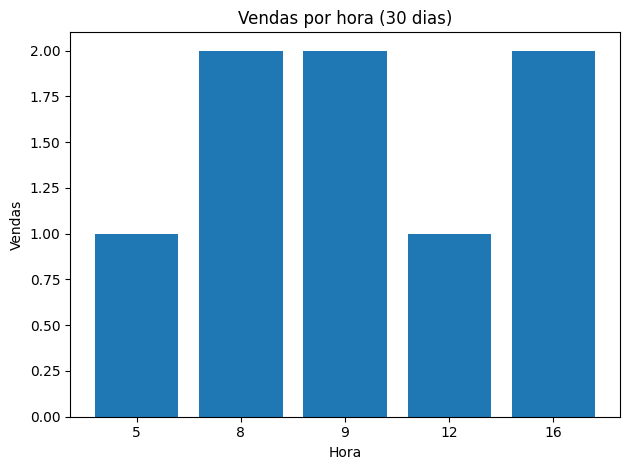

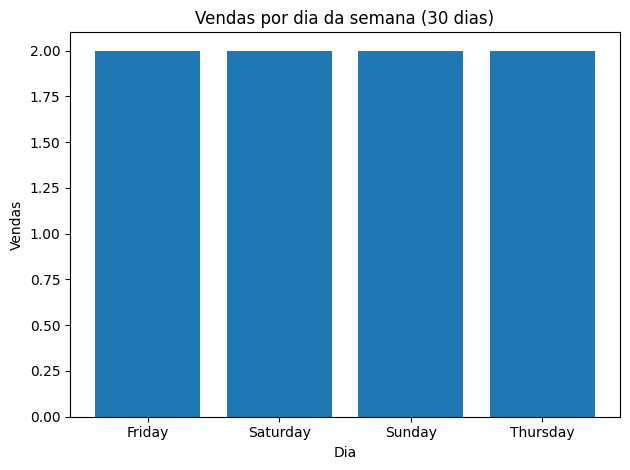

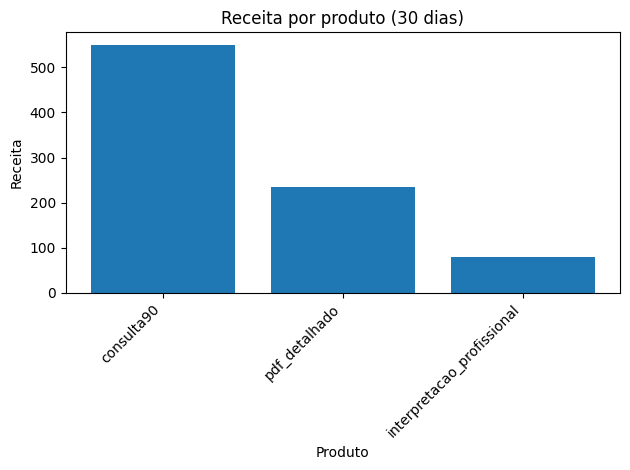

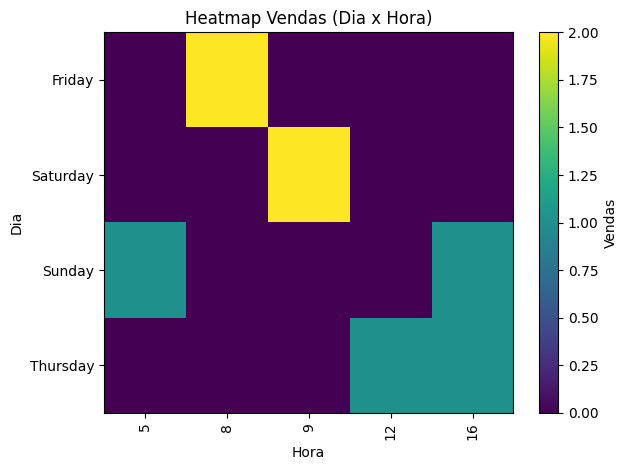

📊 Criando aba Dashboard...
📐 Colunas autoajustadas em 📋 Dashboard
✅ Aba Dashboard criada!


In [ ]:
# === ABA RESUMO — CÉLULA 16 (robusta) ===

# ------------------------
# Títulos das abas
# ------------------------
TAB_TITLES = {
    "consol":        "📘 Consolidado",
    "resumo":        "📊 Resumo",
    "temporal":      "⏱️ Temporal",
    "comparativos":  "📈 Comparativos",
    "produtos":      "📦 Produtos",
    "dashboard":     "📋 Dashboard",
}

# ------------------------
# Imports
# ------------------------
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ------------------------
# Datas-base
# ------------------------
try:
    hoje = datetime.now(TZ).date()  # se TZ já existir
except Exception:
    hoje = datetime.now().date()

if "semana_passada" not in globals():
    semana_passada = hoje - timedelta(days=7)

# fallback para janela 30d se não existir
if "ini_30d" not in globals():
    ini_30d = hoje - timedelta(days=29)

# ------------------------
# Helpers de datas
# ------------------------
def _as_date(x):
    if isinstance(x, str):
        return pd.to_datetime(x, errors="coerce").date()
    return x

def _ensure_date_col(df, col="data"):
    if df is not None and col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce").dt.date

def win(df, inicio, fim, col="data"):
    _ensure_date_col(df, col)
    inicio = _as_date(inicio); fim = _as_date(fim)
    return df[(df[col] >= inicio) & (df[col] <= fim)]

def _coerce_data_date(df):
    if df is not None and "data" in df.columns:
        df["data"] = pd.to_datetime(df["data"], errors="coerce").dt.date

def _coerce_timestamp(dtser):
    try:
        return pd.to_datetime(dtser, errors="coerce", utc=True)
    except Exception:
        return dtser

# força 'data' -> date
for _df in [globals().get("df_all"), globals().get("df_pagos"),
            globals().get("df_pagos_canon"), globals().get("df_conversions_unique")]:
    try:
        _coerce_data_date(_df)
    except Exception:
        pass

# força 'timestamp' -> datetime (utc)
if "df_all" in globals() and "timestamp" in df_all.columns:
    df_all["timestamp"] = _coerce_timestamp(df_all["timestamp"])
if "df_pagos_canon" in globals() and "timestamp" in df_pagos_canon.columns:
    df_pagos_canon["timestamp"] = _coerce_timestamp(df_pagos_canon["timestamp"])

# ------------------------
# Safeguards de tabelas faltantes
# ------------------------
for _name in [
    "vendas_por_hora","vendas_por_dia_semana","contagem_kind","contagem_action","perfil_idade",
    "essencias_populares","df_comparativo_detalhado","df_comparativo_ano",
    "cohort_resumo","cohort_pivot","pricing_produtos",
    "geo_pais_raw","geo_uf_br_raw","geo_pais_unique","geo_uf_br_unique",
    "produtos_vendidos","produtos_interesse","top_abandono"
]:
    if _name not in globals():
        if _name == "produtos_vendidos":
            globals()[_name] = pd.DataFrame(columns=["option","eventos","vendas_sess","receita","orphan_paid"])
        elif _name == "produtos_interesse":
            globals()[_name] = pd.DataFrame(columns=["option","interesses_eventos","interesses_pessoas","interesses_sessoes","conversoes","receita","orphan_paid"])
        elif _name == "top_abandono":
            globals()[_name] = pd.DataFrame(columns=["option","interesses_pessoas","interesses_sessoes","conversoes","gap_pessoas","gap_sessoes","taxa_abandono_%"])
        else:
            globals()[_name] = pd.DataFrame()

# ------------------------
# KPIs / Funil / Orphan flags
# ------------------------
# Harmonizar KPIs
if "kpis" not in globals() and "kpis_df" in globals():
    kpis = kpis_df.copy()

# persons_in_window (caso ainda não exista)
if "persons_in_window" not in globals():
    def persons_in_window(inicio, fim):
        base = df_all.copy()
        base["data"] = pd.to_datetime(base["data"], errors="coerce").dt.date
        if "person_id" not in base.columns:
            base["person_id"] = (
                base.get("email_clean").fillna("").str.strip().str.lower()
                   .where(lambda s: s.ne(""), base.get("phone_e164").fillna("").astype(str))
            )
        mask = (base["data"] >= inicio) & (base["data"] <= fim)
        return (base.loc[mask, ["person_id"]]
                    .replace({"person_id": ["", "nan", "None"]}, pd.NA)
                    .dropna()
                    .drop_duplicates("person_id"))

# Se kpis não existir, calcula o mínimo viável
if "kpis" not in globals():
    def _kpis_periodo(inicio, fim):
        ppl = persons_in_window(inicio, fim)
        L = int(ppl["person_id"].nunique())
        pagos_win = df_pagos_canon[(df_pagos_canon["data"] >= inicio) & (df_pagos_canon["data"] <= fim)]
        V = int(len(pagos_win))
        R = float(pagos_win["price_num"].sum())
        Conv = round(100 * V / max(L, 1), 2)
        return L, V, R, Conv

    L30, V30, R30, C30 = _kpis_periodo(ini_30d, hoje)
    kpis = pd.DataFrame({
        "Metrica": ["Leads 30 dias","Vendas 30 dias","Receita 30 dias","Conversão 30 dias"],
        "Valor":   [L30, V30, R30, C30],
    })

# Mapa de KPIs
kmap = {str(m): v for m, v in zip(kpis["Metrica"], kpis["Valor"])}

# Recalcular 30d (atual)
ppl30 = persons_in_window(ini_30d, hoje)
leads_30d   = int(ppl30["person_id"].nunique())
win30       = df_pagos_canon[(df_pagos_canon["data"] >= ini_30d) & (df_pagos_canon["data"] <= hoje)]
vendas_30d  = int(len(win30))
receita_30d = float(win30["price_num"].sum())
ticket_30d  = (receita_30d / vendas_30d) if vendas_30d > 0 else 0.0

# 7d / hoje (opcionalmente lidos do kmap)
leads_7d    = int(kmap.get("Leads 7 dias", 0))
vendas_7d   = int(kmap.get("Vendas 7 dias", 0))
receita_7d  = float(kmap.get("Receita 7 dias", 0.0))
leads_hoje   = int(kmap.get("Leads Hoje", 0))
vendas_hoje  = int(kmap.get("Vendas Hoje", 0))
receita_hoje = float(kmap.get("Receita Hoje", 0.0))

# Funil (fallback)
if "funil" not in globals():
    try:
        if "person_id" not in df_all.columns:
            df_all["person_id"] = (
                df_all.get("email_clean").fillna("")
                     .where(df_all.get("email_clean").fillna("")!="",
                            df_all.get("phone_e164").fillna(""))
            )
        stage = df_all["stage"].astype(str).str.lower() if "stage" in df_all.columns else pd.Series("", index=df_all.index)
        visit_mask      = stage.eq("visit")
        baixou_pdf_mask = stage.eq("baixou_pdf")

        def _nuniq_person(mask_df):
            return (df_all.loc[mask_df, "person_id"]
                        .dropna().replace("", pd.NA).nunique())

        visitantes = _nuniq_person(visit_mask)
        baixou_pdf = _nuniq_person(baixou_pdf_mask)

        if "df_conversions_unique" in globals():
            if "person_id" not in df_conversions_unique.columns:
                df_conversions_unique = df_conversions_unique.merge(
                    df_all[["session_effective","person_id"]].drop_duplicates("session_effective"),
                    on="session_effective", how="left"
                )
            pagou = (df_conversions_unique["person_id"].dropna().replace("", pd.NA).nunique())
        else:
            pagos_mask = df_all.get("is_paid", False)
            pagou = (df_all.loc[pagos_mask, "person_id"].dropna().replace("", pd.NA).nunique())

        funil = pd.DataFrame(
            {"Etapa": ["Visitantes","Baixou PDF","Pagou"],
             "Únicos": [int(visitantes), int(baixou_pdf), int(pagou)]}
        )
    except Exception:
        funil = pd.DataFrame({"Etapa": [], "Únicos": []})

# Garantir flags de órfãos
if "orphan_paid" not in df_all.columns:
    df_all["is_orphan"]  = df_all.get("is_orphan", False).fillna(False)
    df_all["orphan_paid"] = df_all["is_paid"] & df_all["is_orphan"]

if "produtos_vendidos" in globals() and "orphan_paid" not in produtos_vendidos.columns:
    extra = (df_all.groupby("product", dropna=False)["orphan_paid"].sum().reset_index())
    try:
        produtos_vendidos = produtos_vendidos.merge(extra, on="product", how="left")
        produtos_vendidos["orphan_paid"] = produtos_vendidos["orphan_paid"].fillna(0).astype(int)
    except Exception:
        pass

# ------------------------
# LTV FT / TtC — recompute se faltar e harmoniza
# ------------------------
def _to_ts(s):
    return pd.to_datetime(s, errors="coerce", utc=True)

def _ensure_person_id(df):
    df = df.copy()
    if "person_id" not in df.columns or df["person_id"].isna().all():
        email = df.get("email_clean").fillna("").astype(str).str.strip().str.lower()
        phone = df.get("phone_e164").fillna("").astype(str).str.strip()
        df["person_id"] = email.where(email != "", phone)
    return df

def _recompute_ltv_ft_if_needed():
    global ltv_por_origem, ltv_ft_source
    need = ("ltv_por_origem" not in globals()) or ltv_por_origem is None or len(ltv_por_origem) == 0
    if not need:
        return

    _df = _ensure_person_id(df_all).copy()
    _df["timestamp"] = _to_ts(_df["timestamp"] if "timestamp" in _df.columns else _df.get("__ts"))

    for raw_, clean_ in [("utm_source","utm_source_clean"),("utm_medium","utm_medium_clean"),("utm_campaign","utm_campaign_clean")]:
        if clean_ not in _df.columns:
            _df[clean_] = _df.get(raw_, "").astype(str).str.strip().str.lower()

    # Primeiro toque
    _ft = (_df.sort_values(["person_id","timestamp"], na_position="last")
              .drop_duplicates("person_id", keep="first")
              .loc[:, ["person_id","utm_source_clean","utm_medium_clean","utm_campaign_clean"]])

    _paid = _ensure_person_id(df_pagos_canon).copy()
    _paid["price_num"] = pd.to_numeric(_paid["price_num"], errors="coerce").fillna(0.0)

    _rec = (_paid.groupby("person_id", dropna=False)["price_num"].sum()
                 .rename("LTV").reset_index())

    _ltv_person = _rec.merge(_ft, on="person_id", how="left")

    ltv_por_origem = (
        _ltv_person.groupby("utm_source_clean", dropna=False)
                   .agg(clientes=("person_id","nunique"),
                        LTV_medio=("LTV","mean"),
                        receita=("LTV","sum"))
                   .reset_index()
                   .rename(columns={"utm_source_clean":"utm_source"})
                   .sort_values("receita", ascending=False)
    )
    ltv_ft_source = ltv_por_origem.copy()

def _harmonize_ltv_cols(df, kind="source"):
    if df is None or len(df) == 0:
        return pd.DataFrame()
    df = df.copy()
    if kind == "source":
        if "utm_source" not in df.columns:
            if "utm_source_clean" in df.columns:
                df = df.rename(columns={"utm_source_clean":"utm_source"})
            else:
                first_col = df.columns[0]
                if first_col not in ["utm_source","pessoas","pagantes","conv_rate_%","receita",
                                     "LTV_medio_pagante","LTV_medio_pessoa","ttc_mediana_dias","ttc_media_dias"]:
                    df = df.rename(columns={first_col:"utm_source"})
    wanted = ["pessoas","pagantes","conv_rate_%","receita",
              "LTV_medio_pagante","LTV_medio_pessoa","ttc_mediana_dias","ttc_media_dias"]
    low = {c.lower(): c for c in df.columns}
    for c in wanted:
        if c not in df.columns and c.lower() in low:
            df = df.rename(columns={low[c.lower()]: c})
    return df

if "ltv_por_origem" not in globals():
    ltv_por_origem = pd.DataFrame()
_recompute_ltv_ft_if_needed()
ltv_por_origem = _harmonize_ltv_cols(ltv_por_origem, "source")
ltv_ft_source  = ltv_por_origem.copy() if len(ltv_por_origem) else pd.DataFrame()

print("LTV por origem (linhas):", len(ltv_por_origem))

# ------------------------
# ABA RESUMO
# ------------------------
print("📊 Criando aba Resumo...")
sheet_resumo = reset_sheet(spreadsheet, TAB_TITLES["resumo"], rows=2000, cols=26)
tabelas_resumo = [
    ("🎯 KPIs PRINCIPAIS", kpis),
    ("🔄 FUNIL DE CONVERSÃO", funil),
    ("📦 PRODUTOS MAIS VENDIDOS", produtos_vendidos.head(10)),
    ("🌟 ESSÊNCIAS POPULARES", essencias_populares),
    ("🚨 ALERTAS", alertas_df if "alertas_df" in globals() else pd.DataFrame({"Alertas": ["Sem alertas"]})),
    ("🌍 GEO por País (RAW)", geo_pais_raw.head(10)),
    ("🇧🇷 GEO por UF (BR) (RAW)", geo_uf_br_raw.head(10)),
    ("🌍 GEO por País (UNIQUE)", geo_pais_unique.head(10)),
    ("🇧🇷 GEO por UF (BR) (UNIQUE)", geo_uf_br_unique.head(10)),
]
linhas_resumo = criar_aba_otimizada(sheet_resumo, "RELATÓRIO ANALYTICS", tabelas_resumo, timestamp_atual)
autoajustar_colunas(sheet_resumo, maxcols=26)
time.sleep(0.5)

# ------------------------
# ABA TEMPORAL
# ------------------------
print("📅 Criando aba Temporal...")
sheet_temporal = reset_sheet(spreadsheet, TAB_TITLES["temporal"], rows=2000, cols=26)
tabelas_temporal = [
    ("⏰ VENDAS POR HORA", vendas_por_hora),
    ("📅 VENDAS POR DIA DA SEMANA", vendas_por_dia_semana),
    ("📢 CONTAGEM POR KIND", contagem_kind),
    ("⚡ CONTAGEM POR ACTION", contagem_action),
    ("👥 PERFIL DEMOGRÁFICO", perfil_idade),
]
linhas_temporal = criar_aba_otimizada(sheet_temporal, "ANÁLISE TEMPORAL", tabelas_temporal, timestamp_atual)
autoajustar_colunas(sheet_temporal, maxcols=35)
time.sleep(0.5)

# ------------------------
# COMPARATIVO DE PRODUTOS (mês atual, canônico)
# ------------------------
ini_mes = hoje.replace(day=1)
fim_mes = hoje
base_mes = df_pagos_canon[(df_pagos_canon["data"] >= ini_mes) & (df_pagos_canon["data"] <= fim_mes)]
comparativo_produtos = (
    base_mes.groupby("option", dropna=False)["session_effective"].nunique()
            .rename("vendas_atual")
            .reset_index()
            .sort_values("vendas_atual", ascending=False)
)

# LTV por produto (canônico)
_ltv = (df_pagos_canon.groupby("option", dropna=False)
         .agg(clientes=("person_id","nunique"), receita=("price_num","sum"))
         .reset_index())
_ltv["LTV_medio"] = (_ltv["receita"] / _ltv["clientes"]).fillna(0.0)
ltv_por_produto = _ltv.sort_values(["receita","clientes"], ascending=[False, False]).copy()

# ------------------------
# PERFORMANCE por UTM (FT + receita canônica)
# ------------------------
_df = df_all.copy()
_df["timestamp"] = pd.to_datetime(_df["timestamp"] if "timestamp" in _df.columns else _df.get("__ts"), errors="coerce")
if "person_id" not in _df.columns:
    _df["person_id"] = (
        _df.get("email_clean").fillna("").str.strip().str.lower()
           .where(lambda s: s.ne(""), _df.get("phone_e164").fillna("").astype(str))
    )

for raw_, clean_ in [("utm_source","utm_source_clean"),("utm_medium","utm_medium_clean"),("utm_campaign","utm_campaign_clean")]:
    if clean_ not in _df.columns:
        _df[clean_] = _df.get(raw_, "").astype(str).str.strip().str.lower()

# escolher sempre a coluna *clean* se existir; senão, a bruta
src_col = "utm_source_clean"   if "utm_source_clean"   in _df.columns else "utm_source"
med_col = "utm_medium_clean"   if "utm_medium_clean"   in _df.columns else "utm_medium"
cmp_col = "utm_campaign_clean" if "utm_campaign_clean" in _df.columns else "utm_campaign"

ft = (
    _df.sort_values(["person_id","timestamp"], na_position="last")
       .dropna(subset=["person_id"])
       .drop_duplicates("person_id", keep="first")
       .loc[:, ["person_id", src_col, med_col, cmp_col]]
       .rename(columns={src_col:"utm_source", med_col:"utm_medium", cmp_col:"utm_campaign"})
)

_paid = df_pagos_canon.copy()
_paid["timestamp"] = pd.to_datetime(_paid["timestamp"] if "timestamp" in _paid.columns else _paid.get("__ts"), errors="coerce")
rec = (_paid.groupby("person_id", dropna=False)
            .agg(receita=("price_num","sum"))
            .reset_index())
rec["converteu"] = rec["receita"] > 0

m = ft.merge(rec, on="person_id", how="left")
m = m.loc[:, ~m.columns.duplicated()]  # <- dedup obrigatório
m["receita"] = m["receita"].fillna(0.0)
m["converteu"] = m["converteu"].fillna(False)

def _perf_by(col, outname):
    g = (m.groupby(col, dropna=False)
           .agg(pessoas=("person_id","nunique"),
                pagantes=("converteu","sum"),
                receita=("receita","sum"))
           .reset_index()
           .rename(columns={col: outname}))
    g["conv_rate_%"] = (g["pagantes"] / g["pessoas"]).fillna(0) * 100
    return g.sort_values("receita", ascending=False)

origem_performance   = _perf_by("utm_source",   "utm_source")
medium_performance   = _perf_by("utm_medium",   "utm_medium")
campaign_performance = _perf_by("utm_campaign", "utm_campaign")

# ------------------------
# ABA COMPARATIVOS
# ------------------------
print("📊 Criando aba Comparativos...")
sheet_comparativos  = reset_sheet(spreadsheet, TAB_TITLES["comparativos"], rows=2000, cols=26)
tabelas_comparativos = [
    ("📈 COMPARATIVO MENSAL DETALHADO", df_comparativo_detalhado),
    ("📊 COMPARATIVO COM ANO ANTERIOR", df_comparativo_ano),
    ("📦 COMPARATIVO DE PRODUTOS", comparativo_produtos),
    ("🌐 PERFORMANCE POR UTM Source", origem_performance),
    ("🌐 PERFORMANCE POR UTM Medium", medium_performance),
    ("🌐 PERFORMANCE POR UTM Campaign", campaign_performance),
    ("🌍 GEO por País (RAW)", geo_pais_raw),
    ("🇧🇷 GEO por UF (BR) (RAW)", geo_uf_br_raw),
    ("🌍 GEO por País (UNIQUE)", geo_pais_unique),
    ("🇧🇷 GEO por UF (BR) (UNIQUE)", geo_uf_br_unique),
    ("👥 ANÁLISE COHORT (Resumo)", cohort_resumo),
    ("👥 ANÁLISE COHORT (Matriz Mensal)", cohort_pivot),
]
linhas_comparativos = criar_aba_otimizada(sheet_comparativos, "ANÁLISE COMPARATIVA", tabelas_comparativos, timestamp_atual)
autoajustar_colunas(sheet_comparativos, maxcols=35)
time.sleep(0.5)

# ------------------------
# TOP 5 para Dashboard/Produtos
# ------------------------
if isinstance(produtos_vendidos, pd.DataFrame) and not produtos_vendidos.empty:
    top5 = produtos_vendidos.head(5).copy()
else:
    top5 = pd.DataFrame(columns=["option","eventos","vendas_sess","receita","orphan_paid"])

# ------------------------
# RFM Resumo (único, canônico)
# ------------------------
def _rfm_resumo_from_canon(rfm_df, pagos_canon, all_df):
    pagos = _ensure_person_id(pagos_canon).copy()
    if pagos is None or len(pagos) == 0:
        return pd.DataFrame(columns=["segmento","clientes","receita_total","ticket_medio"])

    pagos["price_num"] = pd.to_numeric(pagos["price_num"], errors="coerce").fillna(0.0)
    pagos["timestamp"] = _to_ts(pagos["timestamp"] if "timestamp" in pagos.columns else pagos.get("__ts"))

    # Caminho A: usar rfm_clientes_df (com person_id + segmento)
    if isinstance(rfm_df, pd.DataFrame) and not rfm_df.empty:
        r = rfm_df.copy()
        if "segmento" not in r.columns and "segment" in r.columns:
            r = r.rename(columns={"segment":"segmento"})
        if not {"person_id","segmento"}.issubset(r.columns):
            r = pd.DataFrame()
        else:
            r["person_id"] = r["person_id"].astype(str).str.strip().str.lower()
            if "person_id" in all_df.columns:
                base_ids = (all_df["person_id"].astype(str).str.strip().str.lower().dropna().unique())
                r = r[r["person_id"].isin(base_ids)]
            ts_col = next((c for c in ["last_purchase_ts","last_ts","__ts","timestamp"] if c in r.columns), None)
            if ts_col:
                r[ts_col] = _to_ts(r[ts_col])
                r = r.sort_values(["person_id", ts_col], na_position="last").drop_duplicates("person_id", keep="last")
            else:
                r = r.drop_duplicates("person_id", keep="last")

        if len(r) > 0:
            rec = (pagos.groupby("person_id", dropna=False)["price_num"].sum()
                         .rename("receita").reset_index())
            out = (r[["person_id","segmento"]].merge(rec, on="person_id", how="left")
                   .fillna({"receita":0.0})
                   .groupby("segmento", dropna=False)
                   .agg(clientes=("person_id","nunique"),
                        receita_total=("receita","sum"))
                   .reset_index())
            out["ticket_medio"] = (out["receita_total"] / out["clientes"].replace({0: np.nan})).fillna(0).round(2)
            return out.sort_values("receita_total", ascending=False).reset_index(drop=True)

    # Caminho B: derivar segmentos simples direto do canônico
    per = (pagos.groupby("person_id", dropna=False)
                 .agg(freq=("event_id","nunique"),
                      receita=("price_num","sum"),
                      last_ts=("timestamp","max"))
                 .reset_index())

    now_ts = pd.Timestamp.now(tz="UTC")
    per["dias_ult_compra"] = (now_ts - per["last_ts"]).dt.days.replace({pd.NaT: 9999})
    q_freq  = per["freq"].quantile(0.90) if len(per) else 0
    q_monet = per["receita"].quantile(0.90) if len(per) else 0

    def _segment(row):
        if row["receita"] >= q_monet and row["freq"] >= 2: return "VIP"
        if row["freq"] >= max(2, q_freq):                 return "Frequente"
        if row["dias_ult_compra"] <= 30:                  return "Recente"
        if 31 <= row["dias_ult_compra"] <= 60 and row["freq"] >= 2: return "Leal"
        if row["dias_ult_compra"] > 60 and row["freq"] >= 1:        return "Em Risco"
        return "Outros"

    per["segmento"] = per.apply(_segment, axis=1)
    out = (per.groupby("segmento", dropna=False)
             .agg(clientes=("person_id","nunique"),
                  receita_total=("receita","sum"))
             .reset_index())
    out["ticket_medio"] = (out["receita_total"] / out["clientes"].replace({0: np.nan})).fillna(0).round(2)
    return out.sort_values("receita_total", ascending=False).reset_index(drop=True)

# Construir e forçar RFM canônico
rfm_resumo_safe = _rfm_resumo_from_canon(
    rfm_clientes_df if "rfm_clientes_df" in globals() else None,
    df_pagos_canon,
    df_all
)
rfm_resumo = rfm_resumo_safe.copy()
print("RFM linhas:", len(rfm_resumo), "| receita_total:", float(rfm_resumo.get("receita_total", pd.Series()).sum()))

# Fix local se houver rfm_clientes_df (apenas para garantir consistência de agregação)
if "rfm_clientes_df" in globals() and isinstance(rfm_clientes_df, pd.DataFrame) and not rfm_clientes_df.empty:
    _paid_pp = (df_pagos_canon.groupby("person_id", dropna=False)
                 .agg(receita=("price_num","sum"))
                 .reset_index())
    _seg = rfm_clientes_df.loc[:, ["person_id","segmento"]].copy()
    _rfm_join = _seg.merge(_paid_pp, on="person_id", how="left")
    _rfm_join["receita"] = _rfm_join["receita"].fillna(0.0)

    rfm_resumo_safe = (_rfm_join.groupby("segmento", dropna=False)
                        .agg(clientes=("person_id","nunique"),
                             receita_total=("receita","sum"))
                        .reset_index())
    rfm_resumo_safe["ticket_medio"] = (
        rfm_resumo_safe["receita_total"] / rfm_resumo_safe["clientes"].replace({0: pd.NA})
    ).fillna(0.0).round(2)
    rfm_resumo_safe = rfm_resumo_safe.sort_values("receita_total", ascending=False).reset_index(drop=True)

print("RFM fonte:", "canônico", "| receita_total=", float(rfm_resumo_safe.get("receita_total", pd.Series()).sum()))

# ------------------------
# ABA PRODUTOS
# ------------------------
print("📦 Criando aba Produtos...")
sheet_produtos = reset_sheet(spreadsheet, TAB_TITLES["produtos"], rows=2000, cols=26)
tabelas_produtos = [
    ("💰 PRODUTOS VENDIDOS", produtos_vendidos),
    ("👀 PRODUTOS COM INTERESSE", produtos_interesse),
    ("💲 PRICING POR PRODUTO", pricing_produtos),
    ("🏆 TOP 5 PRODUTOS", top5),
    ("🧩 TOP ABANDONO", top_abandono),
    ("💸 LTV POR PRODUTO", ltv_por_produto),
]
linhas_produtos = criar_aba_otimizada(sheet_produtos, "ANÁLISE DE PRODUTOS", tabelas_produtos, timestamp_atual)
autoajustar_colunas(sheet_produtos, maxcols=26)
time.sleep(0.5)

# ------------------------
# Estilos das abas (cores)
# ------------------------
def set_tab_color(spreadsheet, ws, rgb):
    try:
        ws2 = spreadsheet.get_worksheet_by_id(ws.id)  # handle fresco
        spreadsheet.batch_update({
            "requests": [{
                "updateSheetProperties": {
                    "properties": {"sheetId": ws2.id,
                                   "tabColor": {"red": rgb[0], "green": rgb[1], "blue": rgb[2]}},
                    "fields": "tabColor"
                }
            }]
        })
    except Exception as e:
        print("warn:set_tab_color:", e)

# Aplicar cores
set_tab_color(spreadsheet, sheet_resumo,       (0.20, 0.60, 0.86))  # azul
set_tab_color(spreadsheet, sheet_temporal,     (0.60, 0.60, 0.60))  # cinza
set_tab_color(spreadsheet, sheet_comparativos, (0.10, 0.70, 0.40))  # verde
set_tab_color(spreadsheet, sheet_produtos,     (0.95, 0.70, 0.20))  # laranja

# Consolidado (se existir em outra célula)
try:
    sheet_consol = spreadsheet.worksheet("Consolidado")
    sheet_consol.update_title("📘 Consolidado")
    set_tab_color(spreadsheet, sheet_consol, (0.10, 0.55, 0.65))
except Exception as e:
    print("warn: consolidado:", e)

from zoneinfo import ZoneInfo
TZ = ZoneInfo("America/Sao_Paulo")

# timestamp canônico -> UTC coerente
if "timestamp" in df_pagos_canon.columns:
    df_pagos_canon["timestamp"] = pd.to_datetime(df_pagos_canon["timestamp"], errors="coerce", utc=True)
else:
    df_pagos_canon["timestamp"] = pd.to_datetime(df_pagos_canon.get("__ts"), errors="coerce", utc=True)

ts_local_paid = df_pagos_canon["timestamp"].dt.tz_convert(TZ)
df_pagos_canon["data"]       = ts_local_paid.dt.date
df_pagos_canon["hora"]       = ts_local_paid.dt.hour
df_pagos_canon["dia_semana"] = ts_local_paid.dt.day_name()

# ------------------------
# Gráficos (30 dias, canônico)
# ------------------------
paid30 = df_pagos_canon[(df_pagos_canon["data"] >= ini_30d) & (df_pagos_canon["data"] <= hoje)].copy()

# Vendas por hora
vh = (paid30.groupby("hora", dropna=False)
      .agg(vendas=("is_paid","size"), receita=("price_num","sum"))
      .reset_index().sort_values("hora"))
plt.figure()
plt.bar(vh["hora"].astype(str), vh["vendas"])
plt.title("Vendas por hora (30 dias)"); plt.xlabel("Hora"); plt.ylabel("Vendas")
plt.tight_layout(); plt.show(); plt.close()

# Vendas por dia da semana
vd = (paid30.groupby("dia_semana", dropna=False)
      .agg(vendas=("is_paid","size"), receita=("price_num","sum"))
      .reset_index())
plt.figure()
plt.bar(vd["dia_semana"].astype(str), vd["vendas"])
plt.title("Vendas por dia da semana (30 dias)"); plt.xlabel("Dia"); plt.ylabel("Vendas")
plt.tight_layout(); plt.show(); plt.close()

# Receita por produto
pp = (paid30.groupby("option", dropna=False)
      .agg(vendas=("is_paid","size"), receita=("price_num","sum"))
      .reset_index().sort_values("receita", ascending=False))
plt.figure()
plt.bar(pp["option"].astype(str), pp["receita"])
plt.title("Receita por produto (30 dias)"); plt.xlabel("Produto"); plt.ylabel("Receita")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show(); plt.close()

# Heatmap Dia x Hora
pivot = paid30.pivot_table(index="dia_semana", columns="hora", values="is_paid", aggfunc="size", fill_value=0)
plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.title("Heatmap Vendas (Dia x Hora)"); plt.xlabel("Hora"); plt.ylabel("Dia")
plt.colorbar(label="Vendas")
plt.xticks(range(len(pivot.columns)), [str(c) for c in pivot.columns], rotation=90)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.tight_layout(); plt.show(); plt.close()

# ------------------------
# Highlights para Dashboard
# ------------------------
# principal_origem pela tabela de performance
if "origem_performance" in globals() and isinstance(origem_performance, pd.DataFrame) and not origem_performance.empty:
    if "leads" not in origem_performance.columns and "pessoas" in origem_performance.columns:
        origem_performance = origem_performance.rename(columns={"pessoas":"leads"})
    if "leads" in origem_performance.columns and "utm_source" in origem_performance.columns:
        principal_origem = origem_performance.sort_values("leads", ascending=False).iloc[0]["utm_source"]
    else:
        principal_origem = "N/A"
else:
    principal_origem = "N/A"

# melhor dia/hora
melhor_dia  = 'N/A'
melhor_hora = 'N/A'
if isinstance(vendas_por_dia_semana, pd.DataFrame) and not vendas_por_dia_semana.empty:
    try:
        melhor_dia = vendas_por_dia_semana.sort_values('vendas', ascending=False).iloc[0]['dia_semana']
    except Exception:
        pass
if isinstance(vendas_por_hora, pd.DataFrame) and not vendas_por_hora.empty:
    try:
        hora_valor = vendas_por_hora.sort_values('vendas', ascending=False).iloc[0]['hora']
        if pd.notna(hora_valor):
            melhor_hora = f"{int(hora_valor):02d}:00h"
    except Exception:
        pass

# produto_top guard
if "produto_top" not in globals():
    if isinstance(produtos_vendidos, pd.DataFrame) and not produtos_vendidos.empty and "option" in produtos_vendidos.columns:
        produto_top = str(produtos_vendidos.sort_values(["receita","eventos"], ascending=[False, False]).iloc[0]["option"])
    else:
        produto_top = "N/A"

# Resumo executivo
taxa_30d = (vendas_30d / max(leads_30d, 1)) * 100
try:
    taxa_hist = float(
        cohort_resumo.loc[
            cohort_resumo["Métrica"].astype(str).str.lower().eq("taxa conversão clientes (%)"),
            "Valor"
        ].iloc[0]
    )
except Exception:
    taxa_hist = float("nan")

dashboard_executivo = pd.DataFrame({
    'Métrica Chave': [
        'Total de Leads (30d)','Total de Vendas (30d)','Receita Total (30d)',
        'Taxa Conversão 30d (%)','Taxa Conversão Histórica (%)','Ticket Médio',
        'Produto Top','Melhor Dia da Semana','Melhor Horário','Principal Origem','Status Geral'
    ],
    'Valor': [
        f"{leads_30d:,}", f"{vendas_30d:,}", f"R$ {receita_30d:,.2f}",
        f"{taxa_30d:.1f}%",
        (f"{taxa_hist:.2f}%" if pd.notna(taxa_hist) else "—"),
        f"R$ {(receita_30d/max(vendas_30d,1)):,.2f}",
        produto_top, melhor_dia, melhor_hora, principal_origem,
        '🟢 Operacional' if vendas_30d > 0 else '🔴 Verificar'
    ]
})

dashboard_aux = pd.DataFrame({
    'Metrica': ['Leads 30d','Vendas 30d','Receita 30d','Taxa Conversão (%)','Ticket Médio'],
    'Valor': [
        int(leads_30d), int(vendas_30d), float(receita_30d),
        round((vendas_30d/max(leads_30d,1))*100, 2),
        round((receita_30d/max(vendas_30d,1)) if vendas_30d>0 else 0, 2)
    ]
})

# ------------------------
# ABA DASHBOARD
# ------------------------
print("📊 Criando aba Dashboard...")
sheet_dashboard = reset_sheet(spreadsheet, TAB_TITLES["dashboard"], rows=2000, cols=26)

# --- LTV FT + TtC (construção direta p/ Dashboard) ---
import numpy as np
import pandas as pd

def _to_ts(s):
    return pd.to_datetime(s, errors="coerce")

def _ensure_person_id(df):
    df = df.copy()
    if "person_id" not in df.columns or df["person_id"].isna().all():
        email = df.get("email_clean","").astype(str).str.strip().str.lower()
        phone = df.get("phone_e164","").astype(str).str.strip()
        sess  = df.get("session_effective","").astype(str)
        df["person_id"] = email.where(email!="", phone.where(phone!="", sess))
    return df

def _clean_utm(df):
    df = df.copy()
    for raw_, clean_ in [("utm_source","utm_source_clean"),
                         ("utm_medium","utm_medium_clean"),
                         ("utm_campaign","utm_campaign_clean")]:
        if clean_ not in df.columns:
            df[clean_] = df.get(raw_,"").astype(str).str.strip().str.lower()
    return df

try:
    # 1) Primeiro toque por pessoa — evitar duplicidades de colunas UTM
    _ev = _ensure_person_id(df_all).pipe(_clean_utm).copy()
    _ev["timestamp"] = _to_ts(_ev["timestamp"] if "timestamp" in _ev.columns else _ev.get("__ts"))

    src_col = "utm_source_clean"   if "utm_source_clean"   in _ev.columns else "utm_source"
    med_col = "utm_medium_clean"   if "utm_medium_clean"   in _ev.columns else "utm_medium"
    cmp_col = "utm_campaign_clean" if "utm_campaign_clean" in _ev.columns else "utm_campaign"

    ft = (
        _ev.sort_values(["person_id","timestamp"], na_position="last")
           .dropna(subset=["person_id"])
           .drop_duplicates("person_id", keep="first")
           .loc[:, ["person_id","timestamp", src_col, med_col, cmp_col]]
           .rename(columns={
               src_col: "utm_source",
               med_col: "utm_medium",
               cmp_col: "utm_campaign",
               "timestamp": "ft_timestamp",
           })
    )
    ft = ft.loc[:, ~ft.columns.duplicated()]

    # 2) Pagos canônicos por pessoa
    p = _ensure_person_id(df_pagos_canon).copy()
    p["timestamp"] = _to_ts(p["timestamp"] if "timestamp" in p.columns else p.get("__ts"))
    p["price_num"] = pd.to_numeric(p.get("price_num"), errors="coerce").fillna(0.0)

    rec = (
        p.groupby("person_id", dropna=False)
         .agg(receita=("price_num","sum"),
              first_paid_ts=("timestamp","min"),
              pedidos=("event_id","count"))
         .reset_index()
    )

    # 3) Join e métricas por origem (FT)
    m = ft.merge(rec, on="person_id", how="left")
    m = m.loc[:, ~m.columns.duplicated()]
    m["receita"]    = m["receita"].fillna(0.0)
    m["converteu"]  = m["receita"] > 0
    m["ttc_dias"]   = (m["first_paid_ts"] - m["ft_timestamp"]).dt.total_seconds() / (3600*24)

    def _agg(df, key):
        g = (df.groupby(key, dropna=False)
               .agg(pessoas=("person_id","nunique"),
                    pagantes=("converteu","sum"),
                    receita=("receita","sum"),
                    ttc_mediana_dias=("ttc_dias","median"),
                    ttc_media_dias=("ttc_dias","mean"))
               .reset_index())
        g["conv_rate_%"]        = (g["pagantes"] / g["pessoas"]).replace([np.inf, np.nan], 0)*100
        g["LTV_medio_pagante"]  = np.where(g["pagantes"]>0, g["receita"]/g["pagantes"], 0.0)
        g["LTV_medio_pessoa"]   = np.where(g["pessoas"]>0,  g["receita"]/g["pessoas"],  0.0)
        return g

    ltv_src = _agg(m, "utm_source")

    # 4) Tabelas finais
    ltv_ft_print = (
        ltv_src.loc[:, ["utm_source","pessoas","pagantes","conv_rate_%","receita",
                        "LTV_medio_pagante","LTV_medio_pessoa","ttc_mediana_dias","ttc_media_dias"]]
               .sort_values("receita", ascending=False)
               .head(5).copy()
    )
    for c in ["conv_rate_%","receita","LTV_medio_pagante","LTV_medio_pessoa"]:
        ltv_ft_print[c] = ltv_ft_print[c].astype(float).round(2)
    for c in ["ttc_mediana_dias","ttc_media_dias"]:
        ltv_ft_print[c] = ltv_ft_print[c].astype(float).round(4)

    ttc_por_origem = (
        ltv_src.loc[:, ["utm_source","ttc_mediana_dias","ttc_media_dias"]]
               .sort_values("ttc_mediana_dias").copy()
    )
    for c in ["ttc_mediana_dias","ttc_media_dias"]:
        ttc_por_origem[c] = ttc_por_origem[c].astype(float).round(4)

except Exception as e:
    ltv_ft_print   = pd.DataFrame({"Observação":[f"Sem dados de LTV FT ({e})"]})
    ttc_por_origem = pd.DataFrame({"Observação":["Sem dados de TtC"]})
# --- FIM BLOCO ---

tabelas_dashboard = [
    ("🎯 RESUMO EXECUTIVO", dashboard_executivo),
    ("📊 RESUMO EXECUTIVO (AUX)", dashboard_aux),
    ("🏆 TOP 5 PRODUTOS", top5),
    ("🧩 TOP ABANDONO", top_abandono),
    ("💸 LTV FT por Origem (Top 5)", ltv_ft_print),
    ("⏱️ Tempo até Conversão (dias) por Origem", ttc_por_origem),
    ("⚠️ ALERTAS PRIORITÁRIOS", alertas_df if "alertas_df" in globals() else pd.DataFrame({"Alertas": ["Sem alertas"]})),
    ("🧮 RFM (Resumo Segmentos)", rfm_resumo_safe),
]

linhas_dashboard = criar_aba_otimizada(sheet_dashboard, "DASHBOARD EXECUTIVO", tabelas_dashboard, timestamp_atual)
autoajustar_colunas(sheet_dashboard, maxcols=26)
set_tab_color(spreadsheet, sheet_dashboard, (0.55, 0.35, 0.80))  # roxo

print("✅ Aba Dashboard criada!")


In [ ]:
# === RESUMO POR MOEDA (Stripe) === 17
paid30 = df_pagos[(df_pagos["data"] >= ini_30d) & (df_pagos["data"] <= hoje)]
if "currency" in paid30.columns:
    resumo_moeda = (paid30.groupby("currency", dropna=False)
                    .agg(vendas=("is_paid","size"),
                         receita=("price_num","sum"))
                    .reset_index()
                    .sort_values("receita", ascending=False))
else:
    resumo_moeda = pd.DataFrame({"currency":[], "vendas":[], "receita":[]})


In [ ]:
# === ABA CONSOLIDADO === 18
print("📚 Criando aba Consolidado...")
sheet_consol = reset_sheet(spreadsheet, TAB_TITLES["consol"], rows=2000, cols=26)  # 📘 Consolidado

# evitar NameError se não houver dashboard_executivo
import pandas as pd
if "dashboard_executivo" not in locals():
    dashboard_executivo = pd.DataFrame({
        "Métrica": ["Leads 30 dias","Vendas 30 dias","Receita 30 dias","Ticket Médio 30 dias"],
        "Valor": [
            kmap.get("Leads 30 dias", 0),
            kmap.get("Vendas 30 dias", 0),
            kmap.get("Receita 30 dias", 0.0),
            kmap.get("Ticket Médio 30 dias", 0.0),
        ]
    })

# Guards para colunas de QC usadas nas formatações
if "missing_selection_after_pay" not in df_all.columns:
    sel_str = df_all.get("selection")
    sel_ok = sel_str.notna() & sel_str.astype(str).str.strip().ne("") & sel_str.astype(str).str.lower().ne("[]")
    df_all["missing_selection_after_pay"] = df_all.get("is_paid", False) & ~sel_ok

if "missing_email_after_pay" not in df_all.columns:
    df_all["missing_email_after_pay"] = df_all.get("is_paid", False) & (
        df_all.get("email_clean").fillna("").eq("") &
        df_all.get("phone_e164").fillna("").eq("")
    )

# Guards de existência para evitar NameError
import pandas as pd

if "df_pares_essencias" not in locals():
    df_pares_essencias = pd.DataFrame({"essencia_a": [], "essencia_b": [], "frequencia": []})
if "essencias_populares" not in locals():
    essencias_populares = pd.DataFrame({"essencia": [], "frequencia": []})
if "produtos_vendidos" not in locals():
    produtos_vendidos = pd.DataFrame(columns=["option","vendas_sess","eventos","receita","orphan_paid"])
if "produtos_interesse" not in locals():
    produtos_interesse = pd.DataFrame(columns=["option","interesses_eventos","interesses_pessoas","interesses_sessoes","conversoes","receita","orphan_paid"])
if "pricing_produtos" not in locals():
    pricing_produtos = pd.DataFrame(columns=["option","preco_medio","receita_total","vendas"])
if "perfil_idade" not in locals():
    perfil_idade = pd.DataFrame(columns=["age_num","leads","conversoes","taxa_conversao"])
if "alertas_df" not in locals():
    alertas_df = pd.DataFrame({"Alertas": []})

# Lista completa de todas as tabelas
tabelas_consol = [
    ("🎯 KPIs PRINCIPAIS", kpis),
    ("🔄 FUNIL DE CONVERSÃO", funil),
    ("📦 PRODUTOS MAIS VENDIDOS", produtos_vendidos),
    ("👀 PRODUTOS COM INTERESSE", produtos_interesse),
    ("💲 PRICING POR PRODUTO", pricing_produtos),
    ("🌟 ESSÊNCIAS POPULARES", essencias_populares),
    ("⏰ VENDAS POR HORA", vendas_por_hora),
    ("📅 VENDAS POR DIA DA SEMANA", vendas_por_dia_semana),
    ("📢 CONTAGEM POR KIND", contagem_kind),
    ("⚡ CONTAGEM POR ACTION", contagem_action),
    ("👥 PERFIL DEMOGRÁFICO", perfil_idade),
    ("📈 COMPARATIVO MENSAL DETALHADO", df_comparativo_detalhado),
    ("📊 COMPARATIVO COM ANO ANTERIOR", df_comparativo_ano),
    ("📦 COMPARATIVO DE PRODUTOS", comparativo_produtos),
    ("🌐 PERFORMANCE POR UTM Source", origem_performance),
    ("🌐 PERFORMANCE POR UTM Medium", medium_performance),
    ("🌐 PERFORMANCE POR UTM Campaign", campaign_performance),
    ("👥 ANÁLISE COHORT (Resumo)", cohort_resumo),
    ("👥 ANÁLISE COHORT (Matriz Mensal)", cohort_pivot),
    ("📊 DASHBOARD EXECUTIVO", dashboard_executivo),
    ("🚨 ALERTAS", alertas_df),
    ("🌍 GEO por País (RAW)", geo_pais_raw),
    ("🇧🇷 GEO por UF (BR) (RAW)", geo_uf_br_raw),
    ("🌍 GEO por País (UNIQUE)", geo_pais_unique),
    ("🇧🇷 GEO por UF (BR) (UNIQUE)", geo_uf_br_unique),
    ("🔥 Heatmap Vendas (Dia x Hora)", heatmap_semana_hora),
    ("🧮 RFM (clientes)", rfm_detalhado),
    ("🧮 RFM (Resumo por Segmento)", rfm_resumo),
    ("💸 LTV por Origem (primeiro toque)", ltv_por_origem),
    ("💸 LTV por Produto", ltv_por_produto),
    ("🔗 Cross-sell (pares consecutivos)", cross_sell),
    ("🔮 Previsão Semanal (MM3)", forecast_semanal),
    ("🧺 Cesta de Essências (Afinidade)", cesta_afinidade),
    ("🔢 Combinações de Essências", df_pares_essencias),
]

linhas_consolidado = criar_aba_otimizada(sheet_consol, "CONSOLIDADO (só tabelas)", tabelas_consol, timestamp_atual)
autoajustar_colunas(sheet_consol, maxcols=26)
time.sleep(0.5)

# === FORMATAÇÃO BÁSICA ===
print("🎨 Aplicando formatações...")

def aplicar_formatacao_basica(sheet):
    try:
        sheet.format('A1:Z1', {
            'textFormat': {'bold': True, 'fontSize': 14},
            'backgroundColor': {'red': 0.2, 'green': 0.6, 'blue': 0.8}
        })
    except Exception as e:
        print(f"Erro na formatação: {e}")

for s in [sheet_resumo, sheet_temporal, sheet_comparativos, sheet_dashboard, sheet_produtos, sheet_consol]:
    try:
        aplicar_formatacao_basica(s)
        time.sleep(0.2)
    except:
        pass

# === TABELAS PARA CONSOLIDADO ===
qualidade = pd.DataFrame({
    "problema": ["orphan_paid", "missing_selection_after_pay"],
    "qtd": [int(df_all["orphan_paid"].sum()), int(df_all["missing_selection_after_pay"].sum())]
})

# Se você usa _write_sheet(...), aplique assim:
# _write_sheet(spreadsheet, "KPIS", kpis_df)
# _write_sheet(spreadsheet, "FUNIL", funil)
# _write_sheet(spreadsheet, "DEMOGRAFIA", demo)
# _write_sheet(spreadsheet, "GEO_PAISES", geo_pais)
# _write_sheet(spreadsheet, "GEO_UF", geo_uf)
# _write_sheet(spreadsheet, "RESUMO_MOEDA", resumo_moeda)
# _write_sheet(spreadsheet, "QUALIDADE", qualidade)

# === RESUMO FINAL ===
print("\n" + "="*60)
print("🎉 ANÁLISE COMPLETA!")
print("="*60)
print(f"📊 Total de registros processados: {len(df_limpo):,}")
print(f"📅 Período analisado: {df_limpo['data'].min()} a {df_limpo['data'].max()}")
print(f"💰 Receita total (30d): R$ {receita_30d:,.2f}")
print(f"🎯 Taxa de conversão (30d): {(vendas_30d/max(leads_30d,1)*100):.1f}%")
print(f"🏆 Produto top: {produto_top}")
print(f"⚠️ Alertas detectados: {len(alertas)}")
print("\n📋 ABAS CRIADAS:")
print("   ✅ Leads_clean - Dados limpos")
print("   ✅ Resumo - KPIs principais")
print("   ✅ Temporal - Análises temporais")
print("   ✅ Comparativos - Comparações periódicas")
print("   ✅ Dashboard - Visão executiva")
print("   ✅ Produtos - Análise detalhada de produtos")
print("   ✅ Consolidado - Todas as tabelas")
print("\n🔗 Acesse: https://docs.google.com/spreadsheets/d/{}/edit".format(spreadsheet.id))
print("="*60)

# Estatísticas de processamento
print("\n📋 ESTATÍSTICAS DE PROCESSAMENTO:")
print(f"1. Total de registros brutos: {len(df_bruto)}")
print(f"2. Registros com pagamento: {len(df_pagos)}")
print(f"3. Event IDs únicos: {df_bruto['event_id'].nunique()}")

# ✅ clientes pagantes únicos por PESSOA na janela [ini_30d, hoje]
clientes_unicos = int(customers_in_window(ini_30d, hoje)["person_id"].nunique())
print(f"4. Clientes únicos: {clientes_unicos}")

print(f"5. Produtos vendidos: {len(produtos_vendidos)}")
print(f"6. Estados brasileiros: {len(geo_uf_br_raw)}")
print(f"\n⏱️ Processamento concluído em: {datetime.now()}")
print("🎯 Pronto para análise!")


📚 Criando aba Consolidado...
📐 Colunas autoajustadas em 📘 Consolidado
🎨 Aplicando formatações...

🎉 ANÁLISE COMPLETA!
📊 Total de registros processados: 31
📅 Período analisado: 2025-09-11 a 2025-09-28
💰 Receita total (30d): R$ 863.00
🎯 Taxa de conversão (30d): 88.9%
🏆 Produto top: pdf_detalhado
⚠️ Alertas detectados: 1

📋 ABAS CRIADAS:
   ✅ Leads_clean - Dados limpos
   ✅ Resumo - KPIs principais
   ✅ Temporal - Análises temporais
   ✅ Comparativos - Comparações periódicas
   ✅ Dashboard - Visão executiva
   ✅ Produtos - Análise detalhada de produtos
   ✅ Consolidado - Todas as tabelas

🔗 Acesse: https://docs.google.com/spreadsheets/d/1p_PEbCayuJIwclsxzM-nFd1uIRNAV6s_6qsQCw_cso0/edit

📋 ESTATÍSTICAS DE PROCESSAMENTO:
1. Total de registros brutos: 31
2. Registros com pagamento: 8
3. Event IDs únicos: 22
4. Clientes únicos: 8
5. Produtos vendidos: 3
6. Estados brasileiros: 6

⏱️ Processamento concluído em: 2025-09-30 13:16:35.377996
🎯 Pronto para análise!


In [ ]:
# === RELATÓRIO DE QUALIDADE DE DADOS === 19

import numpy as np
import pandas as pd

print("==================================================")
print("📋 RELATÓRIO DE QUALIDADE DE DADOS")
print("==================================================")

# --- Audit Link table (reconstrução robusta) ---
import pandas as pd

_paid = df_pagos_canon.copy()

# coalesce do id de sessão efetivo
def _coalesce_session_effective(d):
    s = pd.Series(pd.NA, index=d.index)
    for c in ["session_effective","event_id_linked","session_id_linked","session_id","uuid"]:
        if c in d.columns:
            s = s.fillna(d[c])
    return (s.astype(str)
             .str.strip()
             .replace({"nan": pd.NA, "None": pd.NA, "": pd.NA}))

_paid["session_effective"] = _coalesce_session_effective(_paid)

# timestamps normalizados
_paid["__ts"] = pd.to_datetime(
    _paid["timestamp"] if "timestamp" in _paid.columns else _paid.get("__ts"),
    errors="coerce", utc=True
)

# método de link
_paid["link_method"] = pd.NA
if "event_id_linked" in _paid.columns:
    _paid.loc[_paid["event_id_linked"].notna() & (_paid["event_id_linked"].astype(str)!=""),
              "link_method"] = "event_id_linked"
if "session_id_linked" in _paid.columns:
    _paid.loc[_paid["link_method"].isna() &
              _paid["session_id_linked"].notna() & (_paid["session_id_linked"].astype(str)!=""),
              "link_method"] = "session_id_linked"

# identidade (preferir email)
_paid["__identity"] = (
    _paid.get("email_clean")
         .fillna("")
         .astype(str)
         .str.strip()
         .where(lambda s: s.ne(""),
                _paid.get("phone_e164", "").astype(str).str.strip())
)

cols_keep = ["event_id","session_effective","event_id_linked","session_id_linked",
             "link_method","__identity","__ts","is_paid","price_num","currency",
             "option","is_orphan"]
cols_keep = [c for c in cols_keep if c in _paid.columns]
audit_link = _paid.loc[:, cols_keep].copy()

# ⏱️ delta entre ts do Stripe e o 1º ts da sessão linkada (se existir)
if "timestamp" in df_all.columns:
    _sess_ts = (df_all.loc[:, ["session_effective","timestamp"]]
                      .dropna()
                      .assign(timestamp=pd.to_datetime(df_all["timestamp"], errors="coerce", utc=True))
                      .sort_values(["session_effective","timestamp"])
                      .drop_duplicates("session_effective", keep="first")
                      .rename(columns={"timestamp":"session_ts"}))
    audit_link = audit_link.merge(_sess_ts, on="session_effective", how="left")
    audit_link["abs_min"] = (
        (audit_link["__ts"] - audit_link["session_ts"])
        .dt.total_seconds().abs() / 60.0
    )

def _as_bool_series(obj, index):
    if isinstance(obj, pd.Series):
        return obj.reindex(index).fillna(False).astype(bool)
    return pd.Series(False, index=index, dtype=bool)

# 1) Recalcular flag Stripe canônica
is_stripe_calc = (
    df_all.get("origin","").astype(str).str.lower().eq("stripe")
    | df_all.get("userAgent","").astype(str).str.contains("stripe", case=False, na=False)
    | df_all.get("action","").astype(str).str.lower().eq("paid")
    | df_all.get("kind","").astype(str).str.lower().eq("pagamentoconfirmado")
    | df_all.get("subject","").astype(str).str.contains("pagamento confirmado", case=False, na=False)
)
df_all["is_stripe_event"] = is_stripe_calc

# 2) Máscaras e contagens
stripe = df_all[is_stripe_calc].copy()
stripe_dedup = stripe.drop_duplicates(subset=["event_id"]).copy()

linked = stripe_dedup.get("session_id_linked")
mask_linked = linked.notna() if isinstance(linked, pd.Series) else pd.Series(False, index=stripe_dedup.index)
is_paid_s = _as_bool_series(stripe_dedup.get("is_paid"), stripe_dedup.index)

n_stripe = int(len(stripe_dedup))
n_linked = int(mask_linked.sum())
n_orphan = int((is_paid_s & ~mask_linked).sum())

print("🔗 Linking de Sessões:")
print(f"   Eventos Stripe: {n_stripe}")
print(f"   Linkados: {n_linked} ({round(100*n_linked/max(n_stripe,1),1)}%)")
print(f"   Órfãos: {n_orphan}")

# 3) Auditoria de linking (híbrido, sem depender de heurística antiga)
cols_audit = [
    "event_id",
    "session_effective",
    "event_id_linked",
    "session_id_linked",
    "link_method",          # <- definido na célula 6
    "__identity",
    "__ts",
    "enriched",
    "is_paid",
    "price_num",
    "currency",
    "option",
    "is_orphan",
]

# fonte direta do consolidado, garantindo paid+stripe
audit = df_all[
    df_all.get("is_paid", False) & df_all.get("is_stripe_event", False)
].copy()

# garante colunas ausentes
for c in cols_audit:
    if c not in audit.columns:
        audit[c] = "" if c not in {"is_paid","price_num","is_orphan"} else False

audit = audit.loc[:, cols_audit].sort_values("__ts").tail(10)

print("📄 Audit Link (top 10):")
print(audit)

# 3.2) |Δt| em minutos entre Stripe e sessão linkada (se tivermos ts da sessão)
try:
    if "session_id_linked" in audit_link.columns and "__ts" in df_all.columns:
        pairs = audit_link[mask_linked.reindex(audit_link.index, fill_value=False)][["session_id_linked"]].merge(
            df_all[["event_id","__ts"]].rename(columns={"event_id":"session_id_linked","__ts":"ts_user"}),
            on="session_id_linked", how="left"
        )
        pairs = pairs.join(audit_link.loc[pairs.index, ["__ts"]])
        pairs["abs_min"] = (pairs["__ts"] - pairs["ts_user"]).abs().dt.total_seconds()/60
        audit_link.loc[pairs.index, "abs_min"] = pairs["abs_min"].round(2)
except Exception:
    pass  # silencioso se faltar ts da sessão

# 4) Órfãos detalhados
cols_orph_base = ["event_id","email","phone_e164","__ts","price_num","currency","option","product","__identity"]
cols_orph = [c for c in cols_orph_base if c in stripe_dedup.columns]
orphans = stripe_dedup.loc[(is_paid_s & ~mask_linked), cols_orph].copy()

# 5) Estatísticas de qualidade adicionais
if "abs_min" in audit_link.columns and audit_link["abs_min"].notna().any():
    desc = audit_link.loc[audit_link["abs_min"].notna(), "abs_min"].describe()
    print("⏱️ |Δt| (min) entre Stripe e sessão linkada:")
    print(desc.to_string())

# 6) Saída tabular opcional (Sheets)
try:
    if "_write_sheet" in globals() and "spreadsheet" in globals():
        _write_sheet(spreadsheet, "AUDIT_LINK", audit_link.reset_index(drop=True))
        _write_sheet(spreadsheet, "PAGAMENTOS_ORFAOS", orphans.reset_index(drop=True))
        print("📝 AUDIT_LINK e PAGAMENTOS_ORFAOS enviados ao Sheets.")
except Exception as e:
    print(f"(Aviso) Falha ao escrever no Sheets: {e}")

# 7) Mostra primeiras linhas
print("\n📄 Audit Link (top 10):")
display(audit_link.head(10))
print("\n🧾 Pagamentos Órfãos (top 10):")
display(orphans.head(10))
print("Relatório usa stripe_dedup:", "stripe_dedup" in globals())


📋 RELATÓRIO DE QUALIDADE DE DADOS
🔗 Linking de Sessões:
   Eventos Stripe: 8
   Linkados: 8 (100.0%)
   Órfãos: 0
📄 Audit Link (top 10):
                        event_id                     session_effective  \
24  evt_1S6CRrBh6ngNeJJBjFhTciEp  18d474a5-116b-4bb3-81ef-5173e655162a   
25  evt_1S6Fl4Bh6ngNeJJBZLillHnO  bc894711-9c81-4710-9f30-b04c00082708   
26  evt_1S9Q6XBmXsjTg4ytB7eCOXAB  998ed663-2d7d-440c-ba13-25212e810e22   
27  evt_1S9QIkBmXsjTg4ytXqsCVMtT  55cbf12c-f70a-4762-a5cd-fe299bdd3433   
28  evt_1SBZcsBmXsjTg4ytKQmwv3cD  fbe618ea-e82b-43b7-84c6-f27548bb67ee   
29  evt_1SBZoOBmXsjTg4yt7f5k510B  7f32bf36-6b61-4e02-9e47-8def92fdb373   
30  evt_1SCGHnBmXsjTg4ytUqkBWvx9  1eb35d1a-6c0e-4083-8a2d-27da1e9540aa   
23  evt_1SCQl2BmXsjTg4yt5Fn3VCAq  9f9d3c11-5565-4e1d-82ee-8777505a224d   

                         event_id_linked  \
24  18d474a5-116b-4bb3-81ef-5173e655162a   
25  bc894711-9c81-4710-9f30-b04c00082708   
26  998ed663-2d7d-440c-ba13-25212e810e22   
27  55cbf12c-f70a-47

,event_id,session_effective,event_id_linked,session_id_linked,link_method,__identity,__ts,is_paid,price_num,currency,option,is_orphan,session_ts,abs_min
0,evt_1SCQl2BmXsjTg4yt5Fn3VCAq,9f9d3c11-5565-4e1d-82ee-8777505a224d,9f9d3c11-5565-4e1d-82ee-8777505a224d,5e417e67-0b85-42e0-aa69-4bd92af1d753,event_id_linked,sdfk@oh.df,2025-09-28 19:59:45.156000+00:00,True,39.0,brl,pdf_detalhado,False,2025-09-28 19:59:14.299000+00:00,0.514283
1,evt_1S6CRrBh6ngNeJJBjFhTciEp,18d474a5-116b-4bb3-81ef-5173e655162a,18d474a5-116b-4bb3-81ef-5173e655162a,18d474a5-116b-4bb3-81ef-5173e655162a,event_id_linked,ordgen@yahoo.com,2025-09-11 15:30:12.839000+00:00,True,39.0,brl,pdf_detalhado,False,2025-09-11 15:29:37.546000+00:00,0.588217
2,evt_1S6Fl4Bh6ngNeJJBZLillHnO,bc894711-9c81-4710-9f30-b04c00082708,bc894711-9c81-4710-9f30-b04c00082708,b46530aa-fd87-4e76-be95-983b8f634cf7,event_id_linked,sdfgsdfgf@sdfsdf.com,2025-09-11 19:02:15.665000+00:00,True,39.0,brl,pdf_detalhado,False,2025-09-11 19:01:33.630000+00:00,0.700583
3,evt_1S9Q6XBmXsjTg4ytB7eCOXAB,998ed663-2d7d-440c-ba13-25212e810e22,998ed663-2d7d-440c-ba13-25212e810e22,66f37d9c-5fb5-449f-9395-185c6576aa0b,event_id_linked,shsvsb@shhs.sjsh,2025-09-20 12:41:30.396000+00:00,True,39.0,brl,pdf_detalhado,False,2025-09-20 12:40:55.171000+00:00,0.587083
4,evt_1S9QIkBmXsjTg4ytXqsCVMtT,55cbf12c-f70a-4762-a5cd-fe299bdd3433,55cbf12c-f70a-4762-a5cd-fe299bdd3433,55cbf12c-f70a-4762-a5cd-fe299bdd3433,event_id_linked,sdfd@sdfd.df,2025-09-20 12:54:07.616000+00:00,True,39.0,brl,pdf_detalhado,False,2025-09-20 12:53:33.495000+00:00,0.568683
5,evt_1SBZcsBmXsjTg4ytKQmwv3cD,fbe618ea-e82b-43b7-84c6-f27548bb67ee,fbe618ea-e82b-43b7-84c6-f27548bb67ee,fbe618ea-e82b-43b7-84c6-f27548bb67ee,event_id_linked,spa8sdf@sdfjk.com,2025-09-26 11:15:46.660000+00:00,True,79.0,brl,interpretacao_profissional,False,2025-09-26 11:15:21.367000+00:00,0.421550
6,evt_1SBZoOBmXsjTg4yt7f5k510B,7f32bf36-6b61-4e02-9e47-8def92fdb373,7f32bf36-6b61-4e02-9e47-8def92fdb373,a5e41374-bdac-4116-a5fa-5f329f077248,event_id_linked,candle@sdfsdf.com,2025-09-26 11:27:41.924000+00:00,True,550.0,brl,consulta90,False,2025-09-26 11:27:11.222000+00:00,0.511700
7,evt_1SCGHnBmXsjTg4ytUqkBWvx9,1eb35d1a-6c0e-4083-8a2d-27da1e9540aa,1eb35d1a-6c0e-4083-8a2d-27da1e9540aa,a925c68d-490c-4a42-9f39-3b808af6ae78,event_id_linked,cuiaba@cuiasfr.cmo,2025-09-28 08:48:52.589000+00:00,True,39.0,brl,pdf_detalhado,False,2025-09-28 08:48:17.225000+00:00,0.589400



🧾 Pagamentos Órfãos (top 10):


,event_id,email,phone_e164,__ts,price_num,currency,option,__identity


Relatório usa stripe_dedup: True


In [ ]:
# SANIDADE RÁPIDA (opcional, última célula) 20
assert "is_stripe_event" in df_all.columns
assert df_all["missing_selection_after_pay"].dtype == bool
assert {"eventos","vendas_sess","receita","orphan_paid"}.issubset(produtos_vendidos.columns)
kmap = {str(m): v for m, v in zip(kpis["Metrica"], kpis["Valor"])}
assert isinstance(kmap, dict) and len(kmap) > 0
print("OK")


OK


In [ ]:
# SANIDADE RÁPIDA DO NOTEBOOK ATUAL 21

ok = True

# 1) Consolidação
ok &= "is_stripe_event" in df_all.columns
ok &= "session_effective" in df_all.columns
ok &= "orphan_paid" in df_all.columns
ok &= "person_id" in df_all.columns
print("Consolidação:", ok)

# 2) Produtos mais vendidos (colunas novas)
req_prod_vendidos = {"option","eventos","vendas_sess","receita","orphan_paid"}
print("produtos_vendidos colunas OK:", "produtos_vendidos" in globals() and req_prod_vendidos.issubset(set(produtos_vendidos.columns)))

# 3) Produtos com interesse (agregado robusto)
req_prod_inter = {"option","interesses_eventos","interesses_pessoas","interesses_sessoes","conversoes","receita","orphan_paid"}
print("produtos_interesse colunas OK:", "produtos_interesse" in globals() and req_prod_inter.issubset(set(produtos_interesse.columns)))

# 4) KPIs para Aba Resumo
if "kpis" not in globals() and "kpis_df" in globals():
    kpis = kpis_df.copy()
print("kpis disponível:", "kpis" in globals())

# 5) Relatório de Qualidade deduplicado
print("Relatório usa stripe_dedup:", "stripe_dedup" in globals())

# 6) Flags de QC
print("missing_selection_after_pay:", "missing_selection_after_pay" in df_all.columns)
print("missing_email_after_pay:", "missing_email_after_pay" in df_all.columns)
log_end("Notebook")


Consolidação: True
produtos_vendidos colunas OK: True
produtos_interesse colunas OK: True
kpis disponível: True
Relatório usa stripe_dedup: True
missing_selection_after_pay: True
missing_email_after_pay: True
{"ts": "2025-09-30T13:16:35.471943+00:00", "level": "INFO", "msg": "END Notebook", "stage": "Notebook", "event": "end"}
